<a href="https://colab.research.google.com/github/meedastitou/computer-vision/blob/main/gridSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import os
import yaml
import numpy as np
import pandas as pd
from itertools import product
from ultralytics import YOLO
import time
import json
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

class CFG:
    DEBUG = False
    SEED = 42
    DATASET_PATH = '/content/drive/MyDrive/dataset'
    NAME = 'detection-PPEv5'
    CLASSES = ['Gloves', 'Glasses', 'Shoes', 'Helmet', 'Vest', 'Person']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)
    NUM_CORES = os.cpu_count()

    # Base training parameters
    EPOCHS = 3 if DEBUG else 20  # Reduced for grid search
    BATCH_SIZE = 16
    OPTIMIZER = 'AdamW'  # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # Model
    YOLO_MODEL = "yolov8m.pt"

    # Output
    OUTPUT_DIR = "/content/drive/MyDrive/PPE-detection/runs"
    ARTIFACTS = '/content/drive/MyDrive/PPE-detection/artifacts'
    GRIDSEARCH_DIR = '/content/drive/MyDrive/PPE-detection/gridsearch/yolov8m'

    # GridSearch parameters
    PARAM_GRID = {
        'lr': [1e-4, 5e-4, 1e-3, 3e-3],
        'optimizer': ['SGD', 'AdamW', 'Adam', 'RMSProp'],
        'batch_size': [8, 16]
    }


In [ ]:
def ensure_dir(dir_path):
    """Create directory if it doesn't exist."""
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Created directory: {dir_path}")

In [ ]:



def run_gridsearch():
    """Run grid search for YOLO training."""
    # Ensure directories exist
    ensure_dir(CFG.OUTPUT_DIR)
    ensure_dir(CFG.ARTIFACTS)
    ensure_dir(CFG.GRIDSEARCH_DIR)

    # Create parameter combinations
    param_keys = list(CFG.PARAM_GRID.keys())
    param_values = list(CFG.PARAM_GRID.values())
    param_combinations = list(product(*param_values))

    # Create results dataframe
    results = []

    # Generate a timestamp for this grid search run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_file = os.path.join(CFG.GRIDSEARCH_DIR, f"gridsearch_results_{timestamp}.csv")

    print(f"Starting grid search with {len(param_combinations)} combinations")

    # Run training for each parameter combination
    for i, combination in enumerate(param_combinations):
        params = dict(zip(param_keys, combination))

        # Create a unique run name
        run_name = f"{CFG.NAME}_gs_{i+1}_{'_'.join([f'{k}_{v}' for k, v in params.items()])}"
        run_name = run_name.replace('.', '')  # Remove dots from name for filesystem compatibility

        print(f"\n{'='*80}")
        print(f"Running combination {i+1}/{len(param_combinations)}")
        print(f"Parameters: {params}")
        print(f"{'='*80}\n")

        # Load base model
        model = YOLO(CFG.YOLO_MODEL)

        # Set up training parameters
        train_args = {
            'data': os.path.join(CFG.DATASET_PATH, 'data.yaml'),
            'epochs': CFG.EPOCHS,
            'imgsz': 640,
            'batch': params['batch_size'],
            'device': 0,
            'workers': CFG.NUM_CORES,
            'project': CFG.OUTPUT_DIR,
            'name': run_name,
            'seed': CFG.SEED,
            'optimizer': params['optimizer'],
            'lr0': params['lr'],  # Initial learning rate
            'weight_decay': CFG.WEIGHT_DECAY,
            'val': True,
            'amp': True,
            'exist_ok': True,
            'resume': False,
            'verbose': False,
        }

        # Start timer
        start_time = time.time()

        # Train model
        results_obj = model.train(**train_args)

        # End timer
        training_time = time.time() - start_time

        # Get metrics
        metrics = {
            'map50': float(results_obj.results_dict.get('metrics/mAP50(B)', 0)),
            'map50_95': float(results_obj.results_dict.get('metrics/mAP50-95(B)', 0)),
            'precision': float(results_obj.results_dict.get('metrics/precision(B)', 0)),
            'recall': float(results_obj.results_dict.get('metrics/recall(B)', 0)),
            'train_time': training_time
        }

        # Add results to list
        result_dict = {**params, **metrics}
        results.append(result_dict)

        # Save intermediate results
        pd.DataFrame(results).to_csv(results_file, index=False)
        print(f"Saved intermediate results to {results_file}")

        # Print current best model based on mAP50-95
        if results:
            df = pd.DataFrame(results)
            best_idx = df['map50_95'].idxmax()
            best_params = df.loc[best_idx].to_dict()
            print("\nCurrent best model:")
            print(f"Parameters: {json.dumps({k: best_params[k] for k in param_keys}, indent=2)}")
            print(f"mAP50-95: {best_params['map50_95']:.4f}")
            print(f"mAP50: {best_params['map50']:4f}")
            print(f"Precision: {best_params['precision']:.4f}")
            print(f"Recall: {best_params['recall']:.4f}")
            print(f"Training time: {best_params['train_time']:.2f} seconds")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Save final results
    results_df.to_csv(results_file, index=False)

    # Find best parameters
    best_idx = results_df['map50_95'].idxmax()
    best_params = results_df.loc[best_idx].to_dict()

    # Create summary file
    summary_file = os.path.join(CFG.GRIDSEARCH_DIR, f"gridsearch_summary_{timestamp}.txt")

    with open(summary_file, 'w') as f:
        f.write(f"Grid Search Summary for {CFG.NAME}\n")
        f.write(f"Timestamp: {timestamp}\n")
        f.write(f"Total combinations: {len(param_combinations)}\n\n")

        f.write("Parameter grid:\n")
        for param, values in CFG.PARAM_GRID.items():
            f.write(f"  {param}: {values}\n")

        f.write("\nBest parameters:\n")
        for param in param_keys:
            f.write(f"  {param}: {best_params[param]}\n")

        f.write("\nBest metrics:\n")
        f.write(f"  mAP50-95: {best_params['map50_95']:.4f}\n")
        f.write(f"  mAP50: {best_params['map50']:.4f}\n")
        f.write(f"  Precision: {best_params['precision']:.4f}\n")
        f.write(f"  Recall: {best_params['recall']:.4f}\n")
        f.write(f"  Training time: {best_params['train_time']:.2f} seconds\n")

    print(f"\nGrid search completed. Results saved to {results_file}")
    print(f"Summary saved to {summary_file}")

    return best_params


In [ ]:

def visualize_results(results_file):
    """Visualize grid search results."""
    # Load results
    results_df = pd.DataFrame(pd.read_csv(results_file))

    # Create plots directory
    plots_dir = os.path.join(CFG.GRIDSEARCH_DIR, 'plots')
    ensure_dir(plots_dir)

    # Import visualization libraries
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Set plot style
    plt.style.use('ggplot')

    # 1. Learning rate vs mAP50-95 for different optimizers
    plt.figure(figsize=(12, 8))
    for optimizer in results_df['optimizer'].unique():
        data = results_df[results_df['optimizer'] == optimizer]
        plt.plot(data['lr'], data['map50_95'], marker='o', label=optimizer)

    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('mAP50-95')
    plt.title('Learning Rate vs mAP50-95 for Different Optimizers')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path = os.path.join(plots_dir, 'lr_vs_map.png')
    plt.savefig(plot_path)

    # 2. Heatmap of mAP50-95 for different optimizers and learning rates
    for batch_size in results_df['batch_size'].unique():
        plt.figure(figsize=(10, 6))
        pivot_df = results_df[results_df['batch_size'] == batch_size].pivot_table(
            index='optimizer', columns='lr', values='map50_95'
        )
        sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.4f')
        plt.title(f'mAP50-95 for Different Optimizers and Learning Rates (Batch Size: {batch_size})')
        plt.tight_layout()
        plot_path = os.path.join(plots_dir, f'heatmap_batch_{batch_size}.png')
        plt.savefig(plot_path)

    # 3. Training time comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='optimizer', y='train_time', hue='batch_size', data=results_df)
    plt.title('Training Time Comparison')
    plt.xlabel('Optimizer')
    plt.ylabel('Training Time (seconds)')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plot_path = os.path.join(plots_dir, 'training_time.png')
    plt.savefig(plot_path)

    print(f"Visualizations saved to {plots_dir}")




In [ ]:
def train_with_best_params(best_params):
    """Train a final model with the best parameters found from grid search."""
    print("\nTraining final model with best parameters...")

    # Create a unique run name for the final model
    run_name = f"{CFG.NAME}_final_{'_'.join([f'{k}_{v}' for k, v in best_params.items() if k in CFG.PARAM_GRID.keys()])}"
    run_name = run_name.replace('.', '')  # Remove dots for filesystem compatibility

    # Load base model
    model = YOLO(CFG.YOLO_MODEL)

    # Set up training parameters with the full number of epochs
    train_args = {
        'data': os.path.join(CFG.DATASET_PATH, 'data.yaml'),
        'epochs': 100,
        'imgsz': 640,
        'batch': best_params['batch_size'],
        'device': 0,
        'workers': CFG.NUM_CORES,
        'project': CFG.OUTPUT_DIR,
        'name': run_name,
        'seed': CFG.SEED,
        'optimizer': best_params['optimizer'],
        'lr0': best_params['lr'],  # Initial learning rate
        'weight_decay': CFG.WEIGHT_DECAY,
        'val': True,
        'amp': True,
        'exist_ok': True,
        'resume': False,
        'verbose': False,
        'patience': CFG.PATIENCE,  # Early stopping patience
    }

    # Train model
    results = model.train(**train_args)

    print(f"\nFinal model training completed.")
    print(f"Model saved to {os.path.join(CFG.OUTPUT_DIR, run_name)}")

    return results


Starting grid search with 32 combinations

Running combination 1/32
Parameters: {'lr': 0.0001, 'optimizer': 'SGD', 'batch_size': 8}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=detection-

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 3.3±4.7 ms, read: 10.7±4.8 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_1_lr_00001_optimizer_SGD_batch_size_8/labels.jpg... 
optimizer: SGD(lr=0.0001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_1_lr_00001_optimizer_SGD_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.32G      1.498      3.164      1.622         90        640: 100%|██████████| 325/325 [00:51<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]

                   all        114        286      0.575      0.167      0.195      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.93G      1.399      2.342       1.54         70        640: 100%|██████████| 325/325 [00:49<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.04it/s]


                   all        114        286      0.634      0.183      0.245      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.93G      1.294      1.963       1.47         58        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.27it/s]


                   all        114        286      0.519      0.399      0.395      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.97G        1.2        1.7       1.41         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.44it/s]

                   all        114        286      0.717      0.486      0.529      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.97G      1.124      1.514      1.351         43        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.40it/s]


                   all        114        286       0.81      0.542      0.598        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.98G      1.105      1.417      1.328        101        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.60it/s]

                   all        114        286       0.84      0.563       0.64      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.02G      1.079      1.334      1.305         67        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.51it/s]

                   all        114        286      0.887      0.549      0.659      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.06G      1.068      1.305      1.299         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.49it/s]

                   all        114        286      0.778       0.61      0.674      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.06G      1.052      1.261      1.279         69        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.49it/s]

                   all        114        286      0.831      0.612      0.705      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.06G      1.036      1.218      1.269         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.79it/s]

                   all        114        286      0.821      0.624      0.702      0.369


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.06G      1.095       1.26      1.297         42        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.55it/s]


                   all        114        286      0.897      0.608      0.725      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.06G      1.075      1.216       1.28         44        640: 100%|██████████| 325/325 [00:48<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.42it/s]


                   all        114        286      0.895      0.623      0.733      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.06G      1.069      1.189       1.28         40        640: 100%|██████████| 325/325 [00:48<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.62it/s]

                   all        114        286      0.793      0.695      0.739      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.06G      1.064      1.171      1.275         29        640: 100%|██████████| 325/325 [00:48<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        114        286        0.8      0.681      0.744      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.06G      1.061      1.155      1.271         21        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.52it/s]

                   all        114        286      0.799       0.69      0.748      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.06G      1.055      1.143      1.266         62        640: 100%|██████████| 325/325 [00:47<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        114        286      0.801      0.697      0.751      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.06G      1.049      1.122      1.263         63        640: 100%|██████████| 325/325 [00:47<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]

                   all        114        286       0.81      0.695      0.751      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.06G      1.044      1.121      1.263         41        640: 100%|██████████| 325/325 [00:47<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        114        286      0.825       0.67      0.752      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.06G      1.047       1.11      1.263         36        640: 100%|██████████| 325/325 [00:47<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.62it/s]

                   all        114        286      0.795        0.7      0.752       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.06G      1.046      1.109       1.26         35        640: 100%|██████████| 325/325 [00:47<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.83it/s]

                   all        114        286      0.803      0.699      0.754      0.418



20 epochs completed in 0.279 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_1_lr_00001_optimizer_SGD_batch_size_8/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_1_lr_00001_optimizer_SGD_batch_size_8/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_1_lr_00001_optimizer_SGD_batch_size_8/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.85it/s]


                   all        114        286      0.794      0.701      0.752      0.421
Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_1_lr_00001_optimizer_SGD_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "SGD",
  "batch_size": 8
}
mAP50-95: 0.4210
mAP50: 0.751822
Precision: 0.7944
Recall: 0.7011
Training time: 1020.59 seconds

Running combination 2/32
Parameters: {'lr': 0.0001, 'optimizer': 'SGD', 'batch_size': 16}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=f

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.0±0.4 ms, read: 5.3±3.7 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_2_lr_00001_optimizer_SGD_batch_size_16/labels.jpg... 
optimizer: SGD(lr=0.0001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_2_lr_00001_optimizer_SGD_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.83G      1.526      3.292      1.637         73        640: 100%|██████████| 163/163 [00:51<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

                   all        114        286      0.221      0.158       0.17      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      7.96G      1.407       2.38      1.544         73        640: 100%|██████████| 163/163 [00:49<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        114        286       0.64      0.188      0.236      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      7.96G      1.291      1.963      1.463         79        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


                   all        114        286      0.478      0.375      0.378      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      7.96G      1.187      1.669      1.397         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

                   all        114        286      0.702      0.492      0.532      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      7.96G      1.111      1.484      1.348         47        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        114        286      0.818      0.559      0.606      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      7.96G      1.089      1.369      1.311        125        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        114        286      0.865      0.544       0.64      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      7.99G      1.057        1.3      1.289         61        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all        114        286      0.829      0.583      0.656      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      7.99G      1.044      1.251      1.285         96        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all        114        286      0.863       0.58      0.675      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      7.99G      1.053      1.238      1.272         83        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        114        286      0.822      0.612      0.695      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         8G      1.036      1.191      1.262        124        640: 100%|██████████| 163/163 [00:49<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        114        286      0.823      0.645      0.714      0.381


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         8G      1.092      1.225      1.292         42        640: 100%|██████████| 163/163 [00:49<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

                   all        114        286      0.847      0.618       0.71      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         8G      1.069      1.179      1.275         44        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        114        286      0.842      0.627      0.716        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.04G       1.06      1.138      1.269         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        114        286      0.842      0.638      0.735        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.04G      1.046      1.116      1.262         29        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        114        286      0.825      0.664      0.742      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.04G      1.046      1.104      1.261         23        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        114        286      0.842      0.674      0.751      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.04G      1.045       1.09      1.251         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        114        286      0.824      0.664      0.748      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.04G      1.046      1.086      1.259         54        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        114        286      0.845      0.652      0.756      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.04G      1.044      1.077      1.256         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.812      0.685      0.757      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.04G      1.034      1.074      1.246         36        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.826      0.681      0.757      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.04G       1.04       1.07      1.252         35        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        114        286      0.841      0.668      0.757      0.416



20 epochs completed in 0.283 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_2_lr_00001_optimizer_SGD_batch_size_16/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_2_lr_00001_optimizer_SGD_batch_size_16/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_2_lr_00001_optimizer_SGD_batch_size_16/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


                   all        114        286      0.827      0.682      0.758      0.419
Speed: 0.2ms preprocess, 6.5ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_2_lr_00001_optimizer_SGD_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "SGD",
  "batch_size": 8
}
mAP50-95: 0.4210
mAP50: 0.751822
Precision: 0.7944
Recall: 0.7011
Training time: 1020.59 seconds

Running combination 3/32
Parameters: {'lr': 0.0001, 'optimizer': 'AdamW', 'batch_size': 8}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 14.8±6.7 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_3_lr_00001_optimizer_AdamW_batch_size_8/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_3_lr_00001_optimizer_AdamW_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.65G      1.166      1.616      1.378         90        640: 100%|██████████| 325/325 [00:52<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.60it/s]

                   all        114        286      0.768      0.546      0.613      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.26G      1.066      1.205       1.27         70        640: 100%|██████████| 325/325 [00:48<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.83it/s]

                   all        114        286      0.882      0.615      0.732       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.32G      1.027      1.106      1.245         58        640: 100%|██████████| 325/325 [00:48<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]

                   all        114        286      0.818      0.727      0.791      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.39G     0.9892      1.005      1.218         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.88it/s]

                   all        114        286       0.86      0.735      0.818      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.46G     0.9552     0.9304      1.184         43        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]

                   all        114        286      0.855      0.693      0.791      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.46G     0.9274     0.8821      1.173        101        640: 100%|██████████| 325/325 [00:48<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        114        286      0.936      0.728      0.829      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.46G      0.911     0.8401      1.156         67        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        114        286      0.892      0.724      0.806      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.46G     0.8817      0.797      1.145         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]

                   all        114        286      0.868      0.716      0.796      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.46G      0.866     0.7746      1.128         69        640: 100%|██████████| 325/325 [00:47<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        114        286      0.924      0.738      0.854      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.46G     0.8422     0.7263      1.108         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]

                   all        114        286      0.862      0.761      0.839      0.548


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.46G     0.8617     0.6686      1.116         42        640: 100%|██████████| 325/325 [00:49<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.52it/s]

                   all        114        286      0.878      0.774      0.857      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.46G     0.8359     0.6286      1.104         44        640: 100%|██████████| 325/325 [00:48<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]

                   all        114        286      0.874      0.749       0.85      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.46G     0.8126     0.6067      1.093         40        640: 100%|██████████| 325/325 [00:47<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        114        286      0.895      0.792      0.865      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.46G     0.7948      0.588       1.08         29        640: 100%|██████████| 325/325 [00:48<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]

                   all        114        286      0.915      0.805      0.866      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.46G     0.7781     0.5551      1.069         21        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.92it/s]

                   all        114        286      0.891      0.818      0.892      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.46G     0.7574      0.539      1.054         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.91it/s]

                   all        114        286      0.906       0.83      0.887      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.46G     0.7422     0.5193      1.046         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]

                   all        114        286      0.949      0.808      0.892      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.46G     0.7249     0.5086      1.039         41        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.92it/s]

                   all        114        286      0.904       0.83      0.892      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.46G     0.7136      0.495      1.034         36        640: 100%|██████████| 325/325 [00:47<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.97it/s]

                   all        114        286      0.879      0.829      0.894      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.46G     0.6957     0.4848      1.022         35        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.88it/s]

                   all        114        286      0.911      0.828      0.897      0.622



20 epochs completed in 0.281 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_3_lr_00001_optimizer_AdamW_batch_size_8/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_3_lr_00001_optimizer_AdamW_batch_size_8/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_3_lr_00001_optimizer_AdamW_batch_size_8/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.70it/s]


                   all        114        286      0.911      0.828      0.896      0.622
Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_3_lr_00001_optimizer_AdamW_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 4/32
Parameters: {'lr': 0.0001, 'optimizer': 'AdamW', 'batch_size': 16}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 4.1±5.1 ms, read: 6.9±8.3 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_4_lr_00001_optimizer_AdamW_batch_size_16/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_4_lr_00001_optimizer_AdamW_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.95G      1.166      1.629      1.374         73        640: 100%|██████████| 163/163 [00:51<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        114        286      0.757      0.574      0.636      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.08G      1.049       1.16      1.256         73        640: 100%|██████████| 163/163 [00:49<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.845      0.634      0.708       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.15G      1.002      1.038      1.215         79        640: 100%|██████████| 163/163 [00:49<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all        114        286      0.918      0.624      0.761      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.15G     0.9673     0.9543      1.194         62        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.893      0.684      0.783      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.21G     0.9341     0.8885      1.178         47        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        114        286      0.855      0.747      0.804      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.21G     0.9181     0.8281      1.149        125        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        114        286       0.95      0.699      0.835      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.21G      0.885      0.793      1.136         61        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.891      0.735       0.83        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.21G     0.8599     0.7533      1.131         96        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.887      0.766      0.841      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.21G      0.858     0.7332       1.12         83        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        114        286      0.913      0.759       0.84      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.22G     0.8313     0.7038      1.101        124        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.937      0.754      0.857       0.54


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.28G     0.8476     0.6369      1.106         42        640: 100%|██████████| 163/163 [00:50<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        114        286      0.942      0.776      0.871      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.35G     0.8254     0.6069      1.094         44        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all        114        286       0.94      0.796      0.865      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.35G     0.7928      0.573      1.071         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        114        286      0.918      0.765      0.857       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.35G     0.7748     0.5523      1.066         29        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        114        286      0.875      0.809      0.875      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.35G      0.757     0.5225      1.053         23        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        114        286      0.958      0.796      0.879      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.35G     0.7338     0.5087      1.033         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        114        286      0.915      0.802      0.874      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.35G     0.7205      0.498      1.031         54        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.948      0.765      0.879      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.35G     0.7034     0.4787      1.022         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.944      0.798      0.888      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.35G     0.6977      0.467      1.013         36        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.928      0.809      0.886      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.35G     0.6807      0.457      1.003         35        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all        114        286      0.918      0.815      0.888      0.606



20 epochs completed in 0.285 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_4_lr_00001_optimizer_AdamW_batch_size_16/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_4_lr_00001_optimizer_AdamW_batch_size_16/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_4_lr_00001_optimizer_AdamW_batch_size_16/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


                   all        114        286      0.944      0.798      0.888      0.609
Speed: 0.2ms preprocess, 6.5ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_4_lr_00001_optimizer_AdamW_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 5/32
Parameters: {'lr': 0.0001, 'optimizer': 'Adam', 'batch_size': 8}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mo

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.7±0.4 ms, read: 6.2±4.1 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_5_lr_00001_optimizer_Adam_batch_size_8/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_5_lr_00001_optimizer_Adam_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.95G       1.17      1.604      1.366         90        640: 100%|██████████| 325/325 [00:52<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.69it/s]


                   all        114        286      0.771      0.567      0.641      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.52G      1.064      1.197      1.263         70        640: 100%|██████████| 325/325 [00:48<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.84it/s]

                   all        114        286      0.835      0.647      0.723      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.54G      1.025      1.086      1.235         58        640: 100%|██████████| 325/325 [00:48<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.83it/s]

                   all        114        286      0.945      0.673      0.797      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       4.6G     0.9869     0.9921       1.22         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.70it/s]

                   all        114        286       0.79      0.731       0.75      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.67G     0.9535      0.929      1.184         43        640: 100%|██████████| 325/325 [00:48<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.89it/s]

                   all        114        286      0.829      0.743      0.806      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.67G     0.9236     0.8788      1.168        101        640: 100%|██████████| 325/325 [00:48<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.72it/s]

                   all        114        286      0.864      0.709      0.817      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.67G     0.9127     0.8452      1.155         67        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.84it/s]

                   all        114        286      0.886      0.723      0.808      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.67G      0.881     0.7925      1.142         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]

                   all        114        286      0.883      0.724      0.825       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.67G     0.8593     0.7694      1.125         69        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]

                   all        114        286      0.926      0.746      0.855      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.67G      0.841     0.7322       1.11         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.94it/s]

                   all        114        286      0.898      0.774      0.862      0.562


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.67G      0.852     0.6678      1.114         42        640: 100%|██████████| 325/325 [00:49<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]

                   all        114        286      0.904      0.778      0.857      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.67G     0.8356     0.6337      1.101         44        640: 100%|██████████| 325/325 [00:47<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.83it/s]

                   all        114        286      0.867      0.807      0.866      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.67G     0.8037     0.6051      1.089         40        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.67it/s]

                   all        114        286      0.914      0.793      0.873      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.67G     0.7904     0.5842      1.081         29        640: 100%|██████████| 325/325 [00:48<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]

                   all        114        286      0.881      0.807       0.88      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.67G      0.778     0.5548      1.067         21        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        114        286      0.901      0.814       0.88      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.67G     0.7554     0.5334      1.049         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.79it/s]

                   all        114        286      0.914      0.809      0.876      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.67G     0.7415     0.5199      1.044         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]

                   all        114        286      0.938      0.791      0.886      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.67G     0.7231     0.5071      1.038         41        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        114        286      0.945      0.791      0.888      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.67G     0.7157     0.4926      1.034         36        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.63it/s]

                   all        114        286      0.929      0.821      0.892       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.67G     0.6999     0.4851      1.022         35        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]

                   all        114        286      0.963      0.793      0.889       0.61



20 epochs completed in 0.281 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_5_lr_00001_optimizer_Adam_batch_size_8/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_5_lr_00001_optimizer_Adam_batch_size_8/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_5_lr_00001_optimizer_Adam_batch_size_8/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]


                   all        114        286      0.926      0.819      0.891      0.611
Speed: 0.2ms preprocess, 4.7ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_5_lr_00001_optimizer_Adam_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 6/32
Parameters: {'lr': 0.0001, 'optimizer': 'Adam', 'batch_size': 16}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mo

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 3.5±6.3 ms, read: 7.7±4.2 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_6_lr_00001_optimizer_Adam_batch_size_16/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_6_lr_00001_optimizer_Adam_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.98G      1.164      1.634      1.365         73        640: 100%|██████████| 163/163 [00:52<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        114        286      0.792      0.519      0.604      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.11G      1.048      1.148      1.248         73        640: 100%|██████████| 163/163 [00:49<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.848      0.622      0.701      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.15G      1.003      1.027      1.216         79        640: 100%|██████████| 163/163 [00:49<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        114        286      0.829      0.651      0.746      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.22G     0.9665     0.9484      1.201         62        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.861      0.742      0.804      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.28G     0.9348     0.8889      1.185         47        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        114        286      0.875       0.71      0.812      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.29G     0.9147     0.8358      1.153        125        640: 100%|██████████| 163/163 [00:49<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.839      0.753      0.828      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.29G     0.8868      0.787      1.136         61        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        114        286      0.927      0.735      0.838      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.29G     0.8649     0.7547      1.137         96        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        114        286      0.876      0.759      0.839      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.29G     0.8547      0.737      1.115         83        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        114        286      0.873      0.776      0.848        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.29G     0.8309     0.7023      1.102        124        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.901      0.769      0.867      0.545


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.29G     0.8509     0.6318      1.109         42        640: 100%|██████████| 163/163 [00:50<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        114        286      0.867      0.824      0.865      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.29G     0.8213     0.6011      1.094         44        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        114        286      0.899      0.792      0.861      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.29G     0.7901     0.5718      1.073         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        114        286      0.914      0.803      0.865      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.29G      0.771     0.5509      1.065         29        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        114        286      0.951      0.792      0.882      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.29G     0.7585     0.5224      1.055         23        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all        114        286      0.926      0.813      0.884      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.29G     0.7377     0.5138      1.036         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all        114        286      0.932      0.816      0.886       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.29G     0.7237     0.5009       1.03         54        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

                   all        114        286       0.94      0.819      0.882      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.29G     0.7014      0.476      1.021         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        114        286      0.946      0.817      0.892      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.29G     0.6969     0.4689      1.012         36        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286       0.94      0.824      0.891        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.29G     0.6797     0.4556      1.005         35        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.958      0.819      0.892        0.6



20 epochs completed in 0.285 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_6_lr_00001_optimizer_Adam_batch_size_16/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_6_lr_00001_optimizer_Adam_batch_size_16/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_6_lr_00001_optimizer_Adam_batch_size_16/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


                   all        114        286      0.959      0.819      0.891        0.6
Speed: 0.2ms preprocess, 6.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_6_lr_00001_optimizer_Adam_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 7/32
Parameters: {'lr': 0.0001, 'optimizer': 'RMSProp', 'batch_size': 8}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.9±0.3 ms, read: 7.7±5.4 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_7_lr_00001_optimizer_RMSProp_batch_size_8/labels.jpg... 
optimizer: RMSprop(lr=0.0001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_7_lr_00001_optimizer_RMSProp_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.83G      2.123       3.17      2.245         90        640: 100%|██████████| 325/325 [00:52<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.40it/s]

                   all        114        286     0.0509     0.0605     0.0161    0.00431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       4.4G      1.749      2.595      1.846         70        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.41it/s]


                   all        114        286    0.00543      0.232     0.0169    0.00407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.42G      1.669      2.468      1.787         58        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.35it/s]

                   all        114        286     0.0339      0.271     0.0321     0.0111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.48G      1.596      2.357      1.742         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]

                   all        114        286      0.362     0.0964     0.0308     0.0121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.55G      1.513      2.254      1.681         43        640: 100%|██████████| 325/325 [00:48<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.99it/s]

                   all        114        286      0.318      0.349      0.103     0.0455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.55G      1.462       2.17      1.634        101        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.04it/s]


                   all        114        286      0.455      0.218      0.225     0.0832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.55G      1.451      2.116      1.625         67        640: 100%|██████████| 325/325 [00:47<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.60it/s]

                   all        114        286      0.316      0.153      0.115     0.0506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.55G      1.411      2.056      1.594         63        640: 100%|██████████| 325/325 [00:47<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.29it/s]


                   all        114        286      0.359      0.118     0.0637     0.0246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.55G      1.392       2.02      1.577         69        640: 100%|██████████| 325/325 [00:47<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        114        286      0.306      0.275      0.187      0.083



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.55G       1.36      1.963      1.554         63        640: 100%|██████████| 325/325 [00:47<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.51it/s]


                   all        114        286      0.252       0.29      0.186     0.0721
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.62G      1.412      1.979      1.609         42        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.67it/s]

                   all        114        286      0.592      0.282      0.321      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.68G      1.387      1.959      1.599         44        640: 100%|██████████| 325/325 [00:47<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.68it/s]


                   all        114        286      0.476      0.326      0.322      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.68G      1.377      1.905      1.577         40        640: 100%|██████████| 325/325 [00:47<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.50it/s]


                   all        114        286      0.535      0.351      0.366      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.68G      1.358       1.87      1.565         29        640: 100%|██████████| 325/325 [00:47<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        114        286      0.506      0.359      0.375      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.68G      1.319      1.813      1.534         21        640: 100%|██████████| 325/325 [00:47<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.84it/s]

                   all        114        286      0.538      0.362      0.371      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.68G      1.319      1.786      1.541         62        640: 100%|██████████| 325/325 [00:47<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.66it/s]


                   all        114        286      0.609      0.366      0.422      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.68G      1.292      1.721      1.513         63        640: 100%|██████████| 325/325 [00:47<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]

                   all        114        286      0.613      0.404      0.434      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.68G      1.257      1.679      1.495         41        640: 100%|██████████| 325/325 [00:47<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]

                   all        114        286      0.658       0.44      0.485      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.68G      1.251       1.64      1.482         36        640: 100%|██████████| 325/325 [00:47<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.68it/s]

                   all        114        286      0.757      0.412      0.506      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.68G      1.233      1.607      1.469         35        640: 100%|██████████| 325/325 [00:47<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.77it/s]

                   all        114        286      0.687      0.466      0.512      0.264



20 epochs completed in 0.279 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_7_lr_00001_optimizer_RMSProp_batch_size_8/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_7_lr_00001_optimizer_RMSProp_batch_size_8/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_7_lr_00001_optimizer_RMSProp_batch_size_8/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]


                   all        114        286      0.694      0.467      0.513      0.265
Speed: 0.2ms preprocess, 4.7ms inference, 0.0ms loss, 7.2ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_7_lr_00001_optimizer_RMSProp_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 8/32
Parameters: {'lr': 0.0001, 'optimizer': 'RMSProp', 'batch_size': 16}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_pa

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.4±1.7 ms, read: 3.3±3.5 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_8_lr_00001_optimizer_RMSProp_batch_size_16/labels.jpg... 
optimizer: RMSprop(lr=0.0001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_8_lr_00001_optimizer_RMSProp_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.99G      2.137      3.333      2.191         73        640: 100%|██████████| 163/163 [00:52<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        114        286    0.00233      0.218    0.00369   0.000907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.12G      1.743      2.563      1.802         73        640: 100%|██████████| 163/163 [00:49<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        114        286     0.0458      0.111     0.0231    0.00983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.15G      1.657      2.409      1.729         79        640: 100%|██████████| 163/163 [00:49<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        114        286      0.696     0.0341     0.0176    0.00464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.22G      1.562      2.277      1.664         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        114        286      0.125      0.142     0.0488     0.0173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.29G      1.509       2.21      1.633         47        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

                   all        114        286      0.178      0.245     0.0851     0.0354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.29G      1.455      2.083      1.582        125        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        114        286      0.261      0.214       0.15     0.0568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.29G      1.412      2.007      1.552         61        640: 100%|██████████| 163/163 [00:49<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.391      0.127     0.0634     0.0251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.29G       1.39      1.969      1.551         96        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all        114        286      0.269      0.235      0.177     0.0755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.29G      1.394      1.942       1.53         83        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        114        286      0.299      0.199      0.181      0.069



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.29G      1.354      1.865        1.5        124        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        114        286      0.428      0.244      0.233      0.107


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.29G      1.409      1.911      1.566         42        640: 100%|██████████| 163/163 [00:49<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


                   all        114        286      0.445      0.295      0.269      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.35G      1.393      1.883      1.553         44        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        114        286      0.511       0.33      0.321      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.35G      1.363      1.807      1.526         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        114        286      0.386      0.207      0.151     0.0654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.35G      1.336      1.762      1.517         29        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

                   all        114        286      0.481      0.317      0.322      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.35G      1.329      1.725      1.507         23        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        114        286      0.548      0.429      0.436      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.35G      1.298      1.674      1.478         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

                   all        114        286      0.458      0.402      0.376      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.35G      1.274      1.627      1.472         54        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        114        286      0.696      0.404      0.477      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.35G      1.254      1.593      1.455         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.697      0.355      0.435      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.35G      1.234      1.564      1.439         36        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        114        286      0.707      0.476       0.55      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.35G      1.212      1.521      1.422         35        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286        0.6      0.445      0.487      0.241



20 epochs completed in 0.286 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_8_lr_00001_optimizer_RMSProp_batch_size_16/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_8_lr_00001_optimizer_RMSProp_batch_size_16/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_8_lr_00001_optimizer_RMSProp_batch_size_16/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


                   all        114        286      0.704      0.476      0.548      0.269
Speed: 0.2ms preprocess, 5.5ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_8_lr_00001_optimizer_RMSProp_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 9/32
Parameters: {'lr': 0.0005, 'optimizer': 'SGD', 'batch_size': 8}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_m

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.5±2.0 ms, read: 12.6±8.8 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_9_lr_00005_optimizer_SGD_batch_size_8/labels.jpg... 
optimizer: SGD(lr=0.0005, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_9_lr_00005_optimizer_SGD_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.79G       1.46      2.788      1.596         90        640: 100%|██████████| 325/325 [00:51<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.68it/s]

                   all        114        286      0.625      0.195      0.256      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.36G      1.233      1.779      1.419         70        640: 100%|██████████| 325/325 [00:48<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.35it/s]


                   all        114        286      0.776      0.498      0.558      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.36G        1.1      1.408       1.32         58        640: 100%|██████████| 325/325 [00:48<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.52it/s]

                   all        114        286       0.86      0.575      0.667      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.36G      1.044      1.213      1.278         62        640: 100%|██████████| 325/325 [00:47<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.51it/s]

                   all        114        286      0.794      0.672      0.748      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.36G     0.9994      1.111      1.237         43        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.64it/s]

                   all        114        286       0.87      0.688      0.776      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       4.4G     0.9845      1.051      1.215        101        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.65it/s]

                   all        114        286       0.86      0.719      0.792      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       4.4G     0.9661     0.9888      1.198         67        640: 100%|██████████| 325/325 [00:47<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        114        286      0.879      0.677      0.786       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       4.4G      0.953     0.9539      1.191         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.56it/s]

                   all        114        286      0.881       0.69      0.794      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       4.4G       0.94     0.9325      1.179         69        640: 100%|██████████| 325/325 [00:48<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.72it/s]

                   all        114        286      0.898      0.716       0.81      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       4.4G     0.9244     0.8935      1.168         63        640: 100%|██████████| 325/325 [00:47<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.65it/s]

                   all        114        286      0.948      0.708      0.825      0.489


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       4.4G     0.9701     0.8585      1.187         42        640: 100%|██████████| 325/325 [00:48<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]

                   all        114        286       0.93      0.728      0.826      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       4.4G     0.9545     0.8262      1.175         44        640: 100%|██████████| 325/325 [00:47<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.77it/s]

                   all        114        286      0.933      0.727       0.83       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       4.4G     0.9368     0.8072      1.172         40        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.84it/s]

                   all        114        286      0.895       0.74      0.832       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       4.4G     0.9304     0.7904      1.163         29        640: 100%|██████████| 325/325 [00:47<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.69it/s]

                   all        114        286      0.931      0.719      0.833      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       4.4G      0.919      0.766      1.156         21        640: 100%|██████████| 325/325 [00:48<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.84it/s]

                   all        114        286      0.943      0.712      0.835      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       4.4G     0.9105     0.7557      1.147         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]

                   all        114        286      0.875      0.736      0.838      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       4.4G     0.9115     0.7411      1.148         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.59it/s]

                   all        114        286      0.864      0.771      0.841      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       4.4G     0.8949     0.7344      1.143         41        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.89it/s]

                   all        114        286      0.907      0.761      0.842      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       4.4G     0.8933      0.729      1.141         36        640: 100%|██████████| 325/325 [00:47<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.80it/s]

                   all        114        286      0.892      0.778      0.843      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       4.4G     0.8919     0.7262      1.137         35        640: 100%|██████████| 325/325 [00:47<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        114        286      0.904      0.758      0.844      0.517



20 epochs completed in 0.279 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_9_lr_00005_optimizer_SGD_batch_size_8/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_9_lr_00005_optimizer_SGD_batch_size_8/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_9_lr_00005_optimizer_SGD_batch_size_8/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.81it/s]


                   all        114        286      0.907      0.762      0.841      0.518
Speed: 0.2ms preprocess, 4.7ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_9_lr_00005_optimizer_SGD_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 10/32
Parameters: {'lr': 0.0005, 'optimizer': 'SGD', 'batch_size': 16}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mod

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.6±0.1 ms, read: 7.9±2.9 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_10_lr_00005_optimizer_SGD_batch_size_16/labels.jpg... 
optimizer: SGD(lr=0.0005, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_10_lr_00005_optimizer_SGD_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.84G      1.493      2.897      1.614         73        640: 100%|██████████| 163/163 [00:51<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


                   all        114        286      0.633      0.189      0.243      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      7.98G      1.241      1.811      1.427         73        640: 100%|██████████| 163/163 [00:49<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

                   all        114        286      0.685        0.5      0.526      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      7.98G       1.09       1.37      1.306         79        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        114        286      0.839      0.583      0.666      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      7.98G       1.02      1.163      1.258         62        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

                   all        114        286      0.817      0.668      0.743      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      7.98G     0.9828      1.062      1.233         47        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        114        286      0.825       0.68      0.783      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         8G     0.9701     0.9934      1.203        125        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.851      0.719      0.803      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.04G     0.9488     0.9437      1.186         61        640: 100%|██████████| 163/163 [00:49<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286       0.87      0.719      0.807      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.04G     0.9338     0.9072      1.184         96        640: 100%|██████████| 163/163 [00:49<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.869      0.749      0.816      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.04G     0.9421     0.9059      1.173         83        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        114        286      0.899      0.729      0.811      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.04G     0.9194     0.8545       1.16        124        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        114        286      0.875      0.747      0.819      0.463


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.04G     0.9601       0.82       1.18         42        640: 100%|██████████| 163/163 [00:49<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]

                   all        114        286      0.944      0.696      0.831      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.04G     0.9424     0.7913      1.166         44        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        114        286      0.907      0.715      0.837      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.04G     0.9255     0.7597      1.154         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        114        286      0.899      0.731      0.831      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.08G     0.9099     0.7409       1.15         29        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.955      0.707      0.828      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.08G     0.9001     0.7217      1.142         23        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        114        286      0.892      0.739      0.832      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.08G     0.8879     0.7099      1.129         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all        114        286      0.872      0.756       0.84      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.08G     0.8853     0.7058      1.134         54        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.904      0.752      0.849      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.08G     0.8791     0.6958       1.13         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        114        286      0.894      0.756      0.848      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.08G     0.8754     0.6919      1.125         36        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

                   all        114        286      0.896      0.765      0.849      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.08G     0.8739     0.6909      1.123         35        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        114        286      0.881      0.763      0.847      0.507



20 epochs completed in 0.283 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_10_lr_00005_optimizer_SGD_batch_size_16/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_10_lr_00005_optimizer_SGD_batch_size_16/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_10_lr_00005_optimizer_SGD_batch_size_16/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


                   all        114        286      0.881      0.763      0.846      0.506
Speed: 0.2ms preprocess, 5.5ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_10_lr_00005_optimizer_SGD_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 11/32
Parameters: {'lr': 0.0005, 'optimizer': 'AdamW', 'batch_size': 8}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_m

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.1±1.3 ms, read: 4.3±4.9 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_11_lr_00005_optimizer_AdamW_batch_size_8/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_11_lr_00005_optimizer_AdamW_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.67G       1.21      1.659      1.403         90        640: 100%|██████████| 325/325 [00:52<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.83it/s]

                   all        114        286      0.675      0.513      0.548      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.28G      1.171      1.385      1.348         70        640: 100%|██████████| 325/325 [00:48<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]

                   all        114        286      0.814      0.576      0.634      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.34G      1.162       1.35      1.345         58        640: 100%|██████████| 325/325 [00:48<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        114        286      0.654      0.605      0.641        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.34G      1.117      1.264      1.328         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.74it/s]

                   all        114        286      0.786      0.629      0.702      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.41G      1.081      1.197      1.302         43        640: 100%|██████████| 325/325 [00:48<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.74it/s]

                   all        114        286      0.788       0.59      0.688      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.41G      1.051       1.12      1.268        101        640: 100%|██████████| 325/325 [00:48<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.71it/s]

                   all        114        286      0.807      0.625      0.677      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.41G      1.034       1.07      1.254         67        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]

                   all        114        286      0.753      0.663      0.704      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.41G     0.9935      1.005      1.229         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]

                   all        114        286      0.841      0.692      0.776      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.41G     0.9711      0.966      1.215         69        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.72it/s]

                   all        114        286      0.925      0.655        0.8      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.41G     0.9476     0.9009      1.191         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.64it/s]

                   all        114        286      0.755      0.755      0.736      0.432


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.41G     0.9724     0.8497      1.212         42        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.79it/s]

                   all        114        286      0.836      0.742      0.827      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.47G     0.9544     0.8138      1.196         44        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        114        286      0.857      0.788      0.831      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.54G     0.9078     0.7554      1.171         40        640: 100%|██████████| 325/325 [00:48<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]

                   all        114        286      0.811      0.799      0.854      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.54G     0.8932     0.7186      1.157         29        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.77it/s]

                   all        114        286      0.851      0.789      0.865      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.54G     0.8662     0.6755      1.142         21        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        114        286      0.887      0.785      0.863      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.54G     0.8326      0.639      1.108         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.94it/s]

                   all        114        286      0.907      0.772       0.86      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.54G     0.8003     0.6002      1.098         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.80it/s]

                   all        114        286      0.881      0.826      0.892      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.54G     0.7738     0.5749      1.086         41        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.65it/s]

                   all        114        286      0.895      0.792      0.883      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.54G      0.755      0.558      1.074         36        640: 100%|██████████| 325/325 [00:48<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.84it/s]

                   all        114        286      0.917      0.799      0.882      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.54G     0.7322     0.5336      1.057         35        640: 100%|██████████| 325/325 [00:48<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.62it/s]

                   all        114        286        0.9      0.807      0.895      0.599



20 epochs completed in 0.282 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_11_lr_00005_optimizer_AdamW_batch_size_8/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_11_lr_00005_optimizer_AdamW_batch_size_8/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_11_lr_00005_optimizer_AdamW_batch_size_8/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


                   all        114        286        0.9      0.807      0.895      0.596
Speed: 0.2ms preprocess, 4.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_11_lr_00005_optimizer_AdamW_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 12/32
Parameters: {'lr': 0.0005, 'optimizer': 'AdamW', 'batch_size': 16}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_past

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.2±1.2 ms, read: 2.9±2.8 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_12_lr_00005_optimizer_AdamW_batch_size_16/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_12_lr_00005_optimizer_AdamW_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       6.9G      1.197      1.634       1.38         73        640: 100%|██████████| 163/163 [00:52<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        114        286      0.754      0.463      0.554      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.06G      1.143      1.299       1.33         73        640: 100%|██████████| 163/163 [00:49<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        114        286      0.592       0.53      0.556      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.13G      1.138       1.27      1.321         79        640: 100%|██████████| 163/163 [00:49<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        114        286      0.791      0.556      0.653      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       8.2G      1.094      1.216      1.301         62        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        114        286      0.839      0.535      0.624      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.26G      1.067      1.132       1.28         47        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        114        286      0.817      0.596      0.685      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.26G       1.03      1.059      1.247        125        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.836      0.633       0.73      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.26G      1.005      1.008      1.231         61        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.846      0.619      0.745      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.26G     0.9782     0.9543      1.214         96        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.864       0.64       0.76      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.26G     0.9688     0.9199      1.199         83        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        114        286      0.834      0.666      0.762      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.26G     0.9295     0.8617      1.173        124        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        114        286      0.868      0.708      0.804      0.466


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.26G     0.9522     0.8106      1.189         42        640: 100%|██████████| 163/163 [00:49<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

                   all        114        286      0.846      0.736      0.833      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.26G     0.9272     0.7599      1.173         44        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        114        286       0.92      0.693      0.837      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.26G     0.8976     0.7084       1.15         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        114        286      0.838      0.742       0.82      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.26G     0.8631     0.6685      1.134         29        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        114        286      0.866      0.779      0.829      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.26G     0.8374     0.6346      1.115         23        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        114        286      0.832      0.801      0.866      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.26G     0.8118     0.6028      1.095         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.895      0.762      0.859      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.26G     0.7802     0.5772      1.079         54        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.899       0.81      0.886      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.26G     0.7474     0.5418      1.067         41        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.908      0.795      0.883       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.26G     0.7345     0.5164       1.05         36        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all        114        286      0.908       0.82      0.882      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.26G     0.7038     0.4957      1.034         35        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all        114        286      0.859      0.857      0.887      0.605



20 epochs completed in 0.286 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_12_lr_00005_optimizer_AdamW_batch_size_16/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_12_lr_00005_optimizer_AdamW_batch_size_16/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_12_lr_00005_optimizer_AdamW_batch_size_16/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


                   all        114        286      0.859      0.855      0.887      0.604
Speed: 0.2ms preprocess, 5.5ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_12_lr_00005_optimizer_AdamW_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 13/32
Parameters: {'lr': 0.0005, 'optimizer': 'Adam', 'batch_size': 8}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.0±0.7 ms, read: 4.4±1.4 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_13_lr_00005_optimizer_Adam_batch_size_8/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_13_lr_00005_optimizer_Adam_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       3.8G      1.211      1.661      1.403         90        640: 100%|██████████| 325/325 [00:52<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.48it/s]


                   all        114        286      0.595      0.489       0.52      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.39G       1.17      1.378      1.346         70        640: 100%|██████████| 325/325 [00:48<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.79it/s]

                   all        114        286      0.832      0.564      0.658      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.45G      1.163      1.338      1.341         58        640: 100%|██████████| 325/325 [00:48<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]

                   all        114        286      0.763      0.535      0.624      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.45G      1.123      1.272      1.327         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        114        286      0.745      0.573      0.647      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.52G       1.08      1.192      1.293         43        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.71it/s]

                   all        114        286      0.833      0.576      0.689      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.52G      1.051      1.133      1.273        101        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.69it/s]

                   all        114        286      0.721      0.619      0.691      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.52G      1.032      1.076      1.254         67        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.89it/s]

                   all        114        286      0.841      0.635      0.688       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.52G     0.9919      1.014      1.229         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.93it/s]

                   all        114        286      0.844      0.685      0.771       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.52G     0.9804     0.9827       1.22         69        640: 100%|██████████| 325/325 [00:48<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.84it/s]

                   all        114        286      0.769      0.737      0.781      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.52G     0.9554     0.9236      1.198         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        114        286      0.807      0.728      0.783      0.453


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.52G      0.972     0.8606      1.212         42        640: 100%|██████████| 325/325 [00:49<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.66it/s]

                   all        114        286       0.93       0.68      0.819      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.59G     0.9553     0.8197      1.195         44        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.66it/s]

                   all        114        286       0.83      0.724      0.812      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.65G     0.9195     0.7653       1.18         40        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.91it/s]

                   all        114        286      0.913      0.699      0.823      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.65G     0.8901     0.7361      1.158         29        640: 100%|██████████| 325/325 [00:47<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.69it/s]

                   all        114        286      0.881      0.761      0.823      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.65G     0.8668     0.6849      1.139         21        640: 100%|██████████| 325/325 [00:47<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]

                   all        114        286      0.869      0.769      0.861      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.65G     0.8404     0.6532      1.114         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.74it/s]

                   all        114        286      0.899      0.773      0.859      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.65G     0.8092     0.6145      1.101         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]

                   all        114        286       0.93      0.781      0.874      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.65G     0.7795     0.5827      1.084         41        640: 100%|██████████| 325/325 [00:47<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.93it/s]

                   all        114        286      0.951      0.758      0.883       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.65G     0.7606     0.5572      1.074         36        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]

                   all        114        286      0.943      0.791       0.89      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.65G     0.7351     0.5342      1.057         35        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.88it/s]

                   all        114        286      0.931      0.814      0.892      0.578



20 epochs completed in 0.282 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_13_lr_00005_optimizer_Adam_batch_size_8/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_13_lr_00005_optimizer_Adam_batch_size_8/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_13_lr_00005_optimizer_Adam_batch_size_8/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.73it/s]


                   all        114        286       0.93      0.814      0.893      0.578
Speed: 0.3ms preprocess, 5.6ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_13_lr_00005_optimizer_Adam_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 14/32
Parameters: {'lr': 0.0005, 'optimizer': 'Adam', 'batch_size': 16}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.8±1.7 ms, read: 2.3±1.9 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_14_lr_00005_optimizer_Adam_batch_size_16/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_14_lr_00005_optimizer_Adam_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.93G      1.201      1.645      1.381         73        640: 100%|██████████| 163/163 [00:52<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        114        286      0.665      0.519      0.554      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.08G      1.141      1.311      1.318         73        640: 100%|██████████| 163/163 [00:49<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        114        286      0.619       0.57      0.591      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.15G      1.136      1.273      1.311         79        640: 100%|██████████| 163/163 [00:49<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        114        286       0.75      0.586      0.631      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.21G      1.102      1.213      1.299         62        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286       0.81      0.595      0.672      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.22G      1.073      1.152      1.282         47        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all        114        286      0.846      0.624       0.73      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.22G      1.044      1.066      1.245        125        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]

                   all        114        286      0.757      0.644      0.681      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.28G      1.005      1.022      1.229         61        640: 100%|██████████| 163/163 [00:49<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.884      0.603      0.736      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.28G      0.973     0.9594      1.211         96        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.818      0.683      0.773      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.28G     0.9711     0.9287      1.198         83        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

                   all        114        286      0.857      0.673      0.775      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.28G     0.9316     0.8718      1.177        124        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all        114        286      0.851       0.71      0.792      0.465


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.28G     0.9632     0.8191      1.196         42        640: 100%|██████████| 163/163 [00:50<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        114        286      0.874      0.697      0.818      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.28G      0.941      0.785      1.182         44        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]

                   all        114        286      0.878      0.723      0.808      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.29G     0.9008     0.7178      1.157         41        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        114        286      0.852      0.747      0.827      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.29G     0.8752      0.689      1.143         29        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        114        286      0.909       0.74      0.824      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.29G     0.8424     0.6464      1.119         23        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        114        286       0.87      0.782      0.842      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.29G      0.815     0.6109      1.102         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.925      0.787      0.868      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.29G     0.7832     0.5807      1.087         54        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.878      0.802      0.881      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.35G     0.7583     0.5487      1.074         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.883      0.806      0.883      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.35G      0.737     0.5212      1.053         36        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        114        286      0.892      0.811      0.876      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.35G     0.7092     0.4999      1.039         35        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        114        286      0.943      0.775      0.889      0.595



20 epochs completed in 0.286 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_14_lr_00005_optimizer_Adam_batch_size_16/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_14_lr_00005_optimizer_Adam_batch_size_16/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_14_lr_00005_optimizer_Adam_batch_size_16/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


                   all        114        286      0.942      0.775      0.889      0.595
Speed: 0.2ms preprocess, 5.5ms inference, 0.1ms loss, 3.7ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_14_lr_00005_optimizer_Adam_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 15/32
Parameters: {'lr': 0.0005, 'optimizer': 'RMSProp', 'batch_size': 8}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_past

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.2±0.9 ms, read: 6.6±4.5 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_15_lr_00005_optimizer_RMSProp_batch_size_8/labels.jpg... 
optimizer: RMSprop(lr=0.0005, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_15_lr_00005_optimizer_RMSProp_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.87G      2.203      3.205      2.353         90        640: 100%|██████████| 325/325 [00:52<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.47it/s]


                   all        114        286      0.671    0.00602   0.000329   5.84e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.43G       1.85      2.726      1.936         70        640: 100%|██████████| 325/325 [00:48<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.32it/s]

                   all        114        286      0.405     0.0507     0.0247    0.00389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.48G      1.777      2.623       1.87         58        640: 100%|██████████| 325/325 [00:48<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.63it/s]

                   all        114        286     0.0535     0.0326     0.0156    0.00527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.55G      1.702      2.543      1.827         62        640: 100%|██████████| 325/325 [00:47<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]

                   all        114        286      0.074      0.216     0.0415     0.0115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.61G      1.617      2.448       1.76         43        640: 100%|██████████| 325/325 [00:48<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.11it/s]


                   all        114        286     0.0685      0.171     0.0395     0.0129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.61G      1.586      2.409      1.736        101        640: 100%|██████████| 325/325 [00:48<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.95it/s]

                   all        114        286     0.0939      0.137     0.0529     0.0191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.61G      1.559      2.334      1.717         67        640: 100%|██████████| 325/325 [00:48<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.10it/s]


                   all        114        286      0.154      0.155     0.0856     0.0264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.61G      1.516      2.285      1.683         63        640: 100%|██████████| 325/325 [00:47<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.53it/s]

                   all        114        286      0.306      0.145      0.115     0.0423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.61G      1.505      2.252      1.667         69        640: 100%|██████████| 325/325 [00:47<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]

                   all        114        286      0.238      0.163      0.118     0.0425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.61G      1.477      2.209      1.639         63        640: 100%|██████████| 325/325 [00:47<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.20it/s]


                   all        114        286      0.283      0.253      0.148     0.0578
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.61G       1.54      2.254      1.707         42        640: 100%|██████████| 325/325 [00:48<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        114        286      0.378      0.169      0.129     0.0508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.61G      1.522      2.228      1.707         44        640: 100%|██████████| 325/325 [00:47<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        114        286      0.278      0.245      0.171     0.0635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.61G      1.491       2.17      1.675         40        640: 100%|██████████| 325/325 [00:47<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.49it/s]

                   all        114        286      0.378      0.253      0.183     0.0669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.61G      1.452      2.127      1.649         29        640: 100%|██████████| 325/325 [00:47<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.41it/s]


                   all        114        286       0.42      0.208      0.206     0.0722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.61G      1.433      2.072      1.626         21        640: 100%|██████████| 325/325 [00:47<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.58it/s]


                   all        114        286      0.349       0.28      0.228     0.0935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.61G      1.426      2.038      1.613         62        640: 100%|██████████| 325/325 [00:47<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.61it/s]


                   all        114        286      0.449      0.288      0.291      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.61G      1.385      1.977      1.593         63        640: 100%|██████████| 325/325 [00:47<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]

                   all        114        286      0.438      0.315      0.292      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.61G      1.355      1.934      1.573         41        640: 100%|██████████| 325/325 [00:47<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.50it/s]


                   all        114        286      0.457      0.326      0.301      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.61G      1.334      1.888      1.556         36        640: 100%|██████████| 325/325 [00:47<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.59it/s]

                   all        114        286      0.529      0.338      0.394      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.68G      1.309      1.852      1.535         35        640: 100%|██████████| 325/325 [00:47<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]

                   all        114        286      0.574      0.378      0.412      0.189



20 epochs completed in 0.280 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_15_lr_00005_optimizer_RMSProp_batch_size_8/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_15_lr_00005_optimizer_RMSProp_batch_size_8/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_15_lr_00005_optimizer_RMSProp_batch_size_8/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]


                   all        114        286      0.573      0.375      0.412       0.19
Speed: 0.2ms preprocess, 5.3ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_15_lr_00005_optimizer_RMSProp_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 16/32
Parameters: {'lr': 0.0005, 'optimizer': 'RMSProp', 'batch_size': 16}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.9±1.0 ms, read: 3.1±3.1 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_16_lr_00005_optimizer_RMSProp_batch_size_16/labels.jpg... 
optimizer: RMSprop(lr=0.0005, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_16_lr_00005_optimizer_RMSProp_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.96G      2.333      3.598       2.41         73        640: 100%|██████████| 163/163 [00:52<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        114        286    0.00135     0.0405   0.000588   0.000184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       8.1G      1.883      2.743      1.948         73        640: 100%|██████████| 163/163 [00:49<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all        114        286      0.337    0.00803    0.00102   0.000251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.14G        1.8      2.619      1.866         79        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        114        286      0.359     0.0504    0.00675    0.00171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.21G      1.718      2.532      1.801         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        114        286     0.0155     0.0263    0.00553    0.00133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.21G      1.646       2.46      1.765         47        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


                   all        114        286      0.386      0.105     0.0393      0.011

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.21G       1.61      2.361      1.719        125        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        114        286     0.0339      0.108      0.024    0.00656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.28G      1.572      2.319      1.696         61        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        114        286     0.0688     0.0599     0.0243    0.00686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.28G      1.544      2.267      1.677         96        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.173      0.136     0.0746     0.0239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.28G      1.531      2.253      1.651         83        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all        114        286      0.114     0.0987     0.0393     0.0127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.28G      1.484      2.161       1.61        124        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all        114        286       0.18      0.157      0.108     0.0438


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.28G       1.56      2.236      1.711         42        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        114        286     0.0483     0.0515     0.0331     0.0105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.28G      1.549       2.21      1.696         44        640: 100%|██████████| 163/163 [00:48<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        114        286      0.453     0.0376     0.0303    0.00915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.28G      1.518       2.17       1.66         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.288       0.14      0.122     0.0432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.28G      1.497      2.124      1.656         29        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all        114        286      0.291      0.186      0.169     0.0562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.28G      1.477      2.066      1.631         23        640: 100%|██████████| 163/163 [00:48<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        114        286      0.296      0.117      0.115     0.0516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.28G      1.442      2.007      1.597         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


                   all        114        286       0.39      0.257      0.258     0.0981

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.28G      1.419      1.959      1.582         54        640: 100%|██████████| 163/163 [00:48<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        114        286      0.486      0.257      0.243      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.28G      1.391       1.92      1.567         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        114        286      0.552      0.219      0.248     0.0943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.28G      1.358      1.889      1.538         36        640: 100%|██████████| 163/163 [00:48<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all        114        286      0.562      0.312      0.343      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.28G      1.341      1.838      1.528         35        640: 100%|██████████| 163/163 [00:48<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        114        286      0.596      0.354      0.403      0.177



20 epochs completed in 0.286 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_16_lr_00005_optimizer_RMSProp_batch_size_16/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_16_lr_00005_optimizer_RMSProp_batch_size_16/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_16_lr_00005_optimizer_RMSProp_batch_size_16/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


                   all        114        286      0.596      0.354      0.404      0.177
Speed: 0.2ms preprocess, 5.8ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_16_lr_00005_optimizer_RMSProp_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 17/32
Parameters: {'lr': 0.001, 'optimizer': 'SGD', 'batch_size': 8}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.7±1.4 ms, read: 3.6±2.8 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_17_lr_0001_optimizer_SGD_batch_size_8/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_17_lr_0001_optimizer_SGD_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       3.7G      1.421      2.571      1.566         90        640: 100%|██████████| 325/325 [00:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.87it/s]


                   all        114        286      0.495      0.372      0.381      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.11G      1.146      1.536      1.355         70        640: 100%|██████████| 325/325 [00:48<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.45it/s]


                   all        114        286      0.816      0.552      0.642      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.11G      1.051      1.245      1.273         58        640: 100%|██████████| 325/325 [00:48<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.84it/s]

                   all        114        286      0.831      0.682      0.756      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.11G      1.011      1.095      1.244         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]

                   all        114        286      0.863      0.725      0.786      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.11G     0.9766     0.9973      1.204         43        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]

                   all        114        286      0.851      0.724      0.802      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.11G     0.9518     0.9483      1.184        101        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]

                   all        114        286      0.911       0.72      0.818      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.11G     0.9346     0.8991      1.175         67        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.95it/s]

                   all        114        286      0.905      0.714      0.816      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.11G     0.9182     0.8511      1.166         63        640: 100%|██████████| 325/325 [00:47<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.84it/s]

                   all        114        286      0.903      0.746      0.828      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.11G     0.9021     0.8298      1.146         69        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.67it/s]

                   all        114        286      0.923      0.717      0.827      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.11G     0.8838     0.7939      1.137         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]

                   all        114        286      0.909      0.771       0.86      0.504


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.11G     0.9144     0.7437      1.151         42        640: 100%|██████████| 325/325 [00:49<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        114        286      0.938      0.732      0.848      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.11G     0.8975     0.7182      1.135         44        640: 100%|██████████| 325/325 [00:48<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.72it/s]

                   all        114        286      0.904      0.759      0.854      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.11G     0.8698     0.6949      1.123         40        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]

                   all        114        286      0.889      0.765      0.848      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.11G     0.8625     0.6723      1.113         29        640: 100%|██████████| 325/325 [00:47<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.74it/s]

                   all        114        286      0.919      0.764      0.863      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.11G     0.8548     0.6513      1.106         21        640: 100%|██████████| 325/325 [00:47<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        114        286      0.934      0.749      0.867      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.11G     0.8354     0.6339      1.095         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.74it/s]

                   all        114        286      0.909      0.782      0.874      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.11G     0.8307     0.6235      1.093         63        640: 100%|██████████| 325/325 [00:47<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.72it/s]

                   all        114        286      0.956      0.738      0.869      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.11G     0.8119      0.613      1.089         41        640: 100%|██████████| 325/325 [00:47<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        114        286      0.918      0.765      0.868      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.11G       0.81     0.6078      1.085         36        640: 100%|██████████| 325/325 [00:47<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]

                   all        114        286      0.882      0.785      0.879      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.11G     0.8053     0.6063       1.08         35        640: 100%|██████████| 325/325 [00:48<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        114        286      0.931      0.778      0.881      0.566



20 epochs completed in 0.279 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_17_lr_0001_optimizer_SGD_batch_size_8/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_17_lr_0001_optimizer_SGD_batch_size_8/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_17_lr_0001_optimizer_SGD_batch_size_8/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.71it/s]


                   all        114        286      0.931      0.778      0.881      0.567
Speed: 0.2ms preprocess, 4.7ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_17_lr_0001_optimizer_SGD_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 18/32
Parameters: {'lr': 0.001, 'optimizer': 'SGD', 'batch_size': 16}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.1±0.6 ms, read: 5.0±6.2 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_18_lr_0001_optimizer_SGD_batch_size_16/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_18_lr_0001_optimizer_SGD_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.85G      1.453      2.677      1.584         73        640: 100%|██████████| 163/163 [00:51<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all        114        286      0.391       0.35      0.336      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      7.99G      1.147      1.544      1.355         73        640: 100%|██████████| 163/163 [00:49<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all        114        286      0.787      0.584      0.623      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         8G      1.034      1.198      1.257         79        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        114        286       0.85      0.627      0.728      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         8G     0.9932      1.047      1.227         62        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        114        286      0.817      0.718      0.781      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         8G     0.9564     0.9586      1.202         47        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        114        286      0.903      0.676      0.793      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         8G     0.9375     0.8973      1.172        125        640: 100%|██████████| 163/163 [00:49<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all        114        286      0.896       0.71      0.815      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.04G     0.9131     0.8519      1.157         61        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        114        286      0.898      0.736      0.837      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.04G     0.8953     0.8161      1.156         96        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        114        286      0.906      0.729       0.83      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.04G     0.9016     0.8153      1.149         83        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.895      0.683       0.82      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.04G     0.8721     0.7643       1.13        124        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        114        286      0.864      0.753      0.846      0.509


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.04G     0.9033     0.7132      1.139         42        640: 100%|██████████| 163/163 [00:50<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        114        286      0.882      0.758      0.847      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.04G     0.8827     0.6837      1.128         44        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.911      0.743      0.845      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.04G     0.8547      0.658      1.111         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        114        286       0.96      0.717       0.85      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.08G     0.8438     0.6343      1.106         29        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        114        286      0.909      0.761      0.861       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.08G     0.8269     0.6127      1.098         23        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.942      0.757      0.874      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.08G     0.8113     0.6038      1.081         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        114        286        0.9      0.791      0.883      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.08G     0.8051     0.5996      1.081         54        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.912      0.788      0.889      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.08G      0.788     0.5828      1.076         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286       0.92      0.804      0.891      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.08G     0.7897     0.5734      1.068         36        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        114        286      0.928      0.797      0.889      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.08G     0.7873       0.57      1.067         35        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.951      0.762      0.887      0.564



20 epochs completed in 0.283 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_18_lr_0001_optimizer_SGD_batch_size_16/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_18_lr_0001_optimizer_SGD_batch_size_16/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_18_lr_0001_optimizer_SGD_batch_size_16/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


                   all        114        286      0.912       0.79      0.887      0.569
Speed: 0.2ms preprocess, 5.7ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_18_lr_0001_optimizer_SGD_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 19/32
Parameters: {'lr': 0.001, 'optimizer': 'AdamW', 'batch_size': 8}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mod

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.7±1.1 ms, read: 3.1±2.6 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_19_lr_0001_optimizer_AdamW_batch_size_8/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_19_lr_0001_optimizer_AdamW_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.78G      1.274      1.742      1.429         90        640: 100%|██████████| 325/325 [00:52<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]


                   all        114        286      0.559      0.328      0.351      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.19G      1.275      1.583      1.422         70        640: 100%|██████████| 325/325 [00:48<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.63it/s]

                   all        114        286      0.609      0.452      0.493      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.22G      1.255      1.557      1.419         58        640: 100%|██████████| 325/325 [00:48<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        114        286      0.602      0.401       0.39      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.22G      1.206       1.46      1.385         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.72it/s]

                   all        114        286      0.766      0.496      0.599      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.29G      1.155      1.379      1.349         43        640: 100%|██████████| 325/325 [00:48<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.64it/s]

                   all        114        286      0.748      0.526      0.607      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.29G      1.122      1.304      1.324        101        640: 100%|██████████| 325/325 [00:48<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.69it/s]

                   all        114        286      0.775      0.572      0.655       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.35G      1.111      1.253      1.314         67        640: 100%|██████████| 325/325 [00:48<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.77it/s]

                   all        114        286      0.818       0.55      0.649      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.35G      1.064       1.19      1.279         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.80it/s]

                   all        114        286      0.747      0.646      0.641      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.35G      1.041      1.128      1.259         69        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.80it/s]

                   all        114        286      0.874      0.657      0.754      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.35G      1.014      1.069       1.24         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]

                   all        114        286      0.843      0.656      0.765      0.395


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.35G      1.055      1.039      1.276         42        640: 100%|██████████| 325/325 [00:48<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.44it/s]

                   all        114        286      0.814      0.676      0.779       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.35G      1.035     0.9963      1.255         44        640: 100%|██████████| 325/325 [00:49<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.61it/s]

                   all        114        286      0.837       0.69      0.774      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.35G      1.002     0.9364      1.236         40        640: 100%|██████████| 325/325 [00:48<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.57it/s]

                   all        114        286      0.866      0.681      0.777      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.42G     0.9707     0.8791      1.218         29        640: 100%|██████████| 325/325 [00:49<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.74it/s]

                   all        114        286      0.801       0.71      0.746      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.42G     0.9459     0.8181      1.199         21        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.61it/s]

                   all        114        286      0.823      0.768      0.827       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.42G     0.9197     0.7888       1.18         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.61it/s]

                   all        114        286      0.912      0.726       0.82      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.42G      0.882     0.7263      1.151         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.77it/s]

                   all        114        286      0.896      0.754      0.847      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.42G     0.8507     0.6929      1.135         41        640: 100%|██████████| 325/325 [00:48<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        114        286       0.89      0.762      0.853      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.42G     0.8281     0.6735      1.122         36        640: 100%|██████████| 325/325 [00:48<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]

                   all        114        286      0.845      0.789       0.86      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.42G     0.7976     0.6347      1.102         35        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.91it/s]

                   all        114        286      0.861      0.777      0.844      0.522



20 epochs completed in 0.283 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_19_lr_0001_optimizer_AdamW_batch_size_8/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_19_lr_0001_optimizer_AdamW_batch_size_8/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_19_lr_0001_optimizer_AdamW_batch_size_8/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]


                   all        114        286      0.861      0.777      0.844       0.52
Speed: 0.2ms preprocess, 6.2ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_19_lr_0001_optimizer_AdamW_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 20/32
Parameters: {'lr': 0.001, 'optimizer': 'AdamW', 'batch_size': 16}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.3±1.1 ms, read: 3.8±3.8 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_20_lr_0001_optimizer_AdamW_batch_size_16/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_20_lr_0001_optimizer_AdamW_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         7G      1.242      1.716      1.431         73        640: 100%|██████████| 163/163 [00:52<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all        114        286      0.592      0.445      0.455      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.14G      1.237      1.512      1.404         73        640: 100%|██████████| 163/163 [00:49<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

                   all        114        286      0.336      0.335      0.276       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.15G      1.238      1.513      1.407         79        640: 100%|██████████| 163/163 [00:49<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.762      0.425      0.523      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.22G      1.187      1.428      1.382         62        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        114        286      0.644      0.526      0.555      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.22G      1.145      1.347      1.349         47        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        114        286      0.618      0.609      0.571      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.22G      1.114      1.243      1.313        125        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        114        286        0.8      0.627      0.689      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.29G      1.085      1.189      1.296         61        640: 100%|██████████| 163/163 [00:49<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        114        286      0.783      0.599      0.678      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.29G      1.046      1.126      1.279         96        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        114        286      0.824      0.579      0.673      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.29G      1.046      1.094       1.26         83        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        114        286      0.778      0.623      0.692      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.29G      1.004      1.023      1.233        124        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        114        286      0.845      0.667      0.755      0.426


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.29G      1.036     0.9854      1.264         42        640: 100%|██████████| 163/163 [00:49<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        114        286       0.89      0.652       0.74      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.29G      1.016     0.9276      1.246         44        640: 100%|██████████| 163/163 [00:49<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.841      0.681      0.763      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.29G     0.9824     0.8703       1.22         41        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.877      0.658       0.77      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.29G     0.9545     0.8281      1.206         29        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.881      0.656      0.797      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.29G     0.9157     0.7719      1.181         23        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.911      0.711       0.81      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.29G     0.8962     0.7463      1.162         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.815      0.736      0.808      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.29G     0.8665     0.7058      1.148         54        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        114        286      0.884      0.711      0.807      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.29G     0.8335     0.6583      1.127         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.878      0.768      0.848      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.29G      0.809     0.6276      1.109         36        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        114        286       0.89      0.775      0.851      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.29G     0.7769     0.5973       1.09         35        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.931       0.76      0.855      0.542



20 epochs completed in 0.286 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_20_lr_0001_optimizer_AdamW_batch_size_16/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_20_lr_0001_optimizer_AdamW_batch_size_16/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_20_lr_0001_optimizer_AdamW_batch_size_16/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


                   all        114        286      0.931       0.76      0.855      0.543
Speed: 0.2ms preprocess, 7.2ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_20_lr_0001_optimizer_AdamW_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 21/32
Parameters: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 8}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mo

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 2.0±1.6 ms, read: 3.2±2.2 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_21_lr_0001_optimizer_Adam_batch_size_8/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_21_lr_0001_optimizer_Adam_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       3.9G      1.274      1.741      1.432         90        640: 100%|██████████| 325/325 [00:52<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.70it/s]

                   all        114        286      0.512       0.38      0.415      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.47G      1.281      1.608      1.434         70        640: 100%|██████████| 325/325 [00:48<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.72it/s]


                   all        114        286      0.663      0.445      0.482      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.49G      1.258      1.577      1.425         58        640: 100%|██████████| 325/325 [00:48<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.57it/s]

                   all        114        286      0.629      0.476      0.499      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.49G      1.216      1.498      1.405         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.64it/s]

                   all        114        286      0.683      0.528      0.583       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.49G      1.158      1.401      1.363         43        640: 100%|██████████| 325/325 [00:48<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.53it/s]


                   all        114        286       0.68      0.538      0.599      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.56G      1.126      1.318      1.337        101        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.76it/s]

                   all        114        286      0.752      0.555      0.634       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.56G      1.111      1.269      1.323         67        640: 100%|██████████| 325/325 [00:49<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.72it/s]

                   all        114        286      0.647      0.601      0.559      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.56G      1.073      1.206      1.293         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]

                   all        114        286      0.754      0.558      0.606      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.56G      1.052      1.155       1.28         69        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.79it/s]

                   all        114        286      0.808      0.614      0.696       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.56G      1.023      1.086      1.254         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]

                   all        114        286      0.844      0.646      0.747      0.382


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.56G      1.051      1.044      1.278         42        640: 100%|██████████| 325/325 [00:49<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        114        286      0.872      0.671       0.74      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.56G      1.045      1.012      1.271         44        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.63it/s]

                   all        114        286       0.85      0.685      0.763      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.62G      1.025     0.9417       1.26         40        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.60it/s]


                   all        114        286      0.875      0.617      0.727      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.62G     0.9876     0.9053      1.232         29        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        114        286      0.821      0.732      0.788      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.62G     0.9566     0.8365      1.209         21        640: 100%|██████████| 325/325 [00:48<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.63it/s]

                   all        114        286      0.886      0.717      0.807      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.62G     0.9174     0.7954      1.182         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.74it/s]

                   all        114        286      0.882      0.732      0.798      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.62G      0.892     0.7451      1.167         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.95it/s]

                   all        114        286      0.903      0.707      0.816       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.62G     0.8556     0.7031      1.149         41        640: 100%|██████████| 325/325 [00:48<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]

                   all        114        286      0.818      0.778      0.818      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.62G      0.831     0.6785      1.133         36        640: 100%|██████████| 325/325 [00:48<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.71it/s]

                   all        114        286      0.886      0.731      0.834      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.69G     0.8024     0.6413      1.112         35        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]

                   all        114        286      0.908      0.756      0.854      0.525



20 epochs completed in 0.282 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_21_lr_0001_optimizer_Adam_batch_size_8/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_21_lr_0001_optimizer_Adam_batch_size_8/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_21_lr_0001_optimizer_Adam_batch_size_8/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.83it/s]


                   all        114        286      0.908      0.756      0.854      0.525
Speed: 0.3ms preprocess, 5.2ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_21_lr_0001_optimizer_Adam_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 22/32
Parameters: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 16}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mo

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.5±0.9 ms, read: 3.8±2.4 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_22_lr_0001_optimizer_Adam_batch_size_16/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_22_lr_0001_optimizer_Adam_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.01G      1.247      1.718      1.423         73        640: 100%|██████████| 163/163 [00:52<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all        114        286      0.593      0.396      0.446       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.14G       1.24      1.515      1.387         73        640: 100%|██████████| 163/163 [00:49<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        114        286      0.603      0.504      0.497      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.15G      1.237      1.485      1.396         79        640: 100%|██████████| 163/163 [00:49<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        114        286       0.55      0.471      0.413      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.22G      1.184      1.411      1.369         62        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        114        286      0.721       0.56      0.607      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.29G      1.145       1.34      1.342         47        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        114        286      0.694      0.558      0.611      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.29G      1.117      1.243      1.309        125        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        114        286      0.801      0.573      0.651      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.35G      1.079      1.195      1.287         61        640: 100%|██████████| 163/163 [00:49<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        114        286       0.85       0.55      0.673      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.35G      1.056      1.141      1.274         96        640: 100%|██████████| 163/163 [00:49<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        114        286      0.787      0.624      0.683      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.35G      1.049      1.084       1.26         83        640: 100%|██████████| 163/163 [00:49<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.843      0.613      0.727      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.35G       1.01      1.022      1.232        124        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        114        286      0.851      0.646      0.741      0.417


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.35G      1.043       0.99      1.261         42        640: 100%|██████████| 163/163 [00:49<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        114        286      0.866      0.645      0.749      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.35G      1.026     0.9507      1.244         44        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        114        286      0.831      0.638      0.732      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.35G     0.9948     0.8821      1.227         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        114        286      0.852      0.643      0.747      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.35G      0.965      0.848      1.211         29        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        114        286      0.862      0.694      0.794      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.35G     0.9305     0.7899      1.192         23        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all        114        286      0.893       0.71      0.818      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.35G     0.9064     0.7561      1.165         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        114        286      0.886       0.73      0.839      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.35G     0.8705     0.7103      1.147         54        640: 100%|██████████| 163/163 [00:49<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.922      0.709       0.84      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.35G     0.8411     0.6698      1.127         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        114        286      0.893      0.743      0.839       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.35G     0.8184     0.6374      1.109         36        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        114        286      0.922      0.724       0.84      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.35G      0.784      0.602      1.088         35        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.895      0.723      0.845      0.537



20 epochs completed in 0.286 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_22_lr_0001_optimizer_Adam_batch_size_16/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_22_lr_0001_optimizer_Adam_batch_size_16/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_22_lr_0001_optimizer_Adam_batch_size_16/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]


                   all        114        286      0.895      0.723      0.845      0.536
Speed: 0.2ms preprocess, 5.7ms inference, 0.1ms loss, 3.1ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_22_lr_0001_optimizer_Adam_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 23/32
Parameters: {'lr': 0.001, 'optimizer': 'RMSProp', 'batch_size': 8}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 2.0±1.7 ms, read: 3.1±2.5 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_23_lr_0001_optimizer_RMSProp_batch_size_8/labels.jpg... 
optimizer: RMSprop(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_23_lr_0001_optimizer_RMSProp_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.95G      2.447      3.527      2.747         90        640: 100%|██████████| 325/325 [00:52<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.61it/s]

                   all        114        286      0.334       0.01    0.00012   2.81e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.36G      1.999      2.908      2.156         70        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.30it/s]

                   all        114        286     0.0162      0.109     0.0138    0.00296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.38G      1.903      2.786      2.059         58        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.72it/s]

                   all        114        286      0.337     0.0683    0.00216   0.000587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.44G      1.819      2.711       2.02         62        640: 100%|██████████| 325/325 [00:47<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.75it/s]

                   all        114        286      0.373     0.0345    0.00983    0.00158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.51G      1.728      2.631      1.938         43        640: 100%|██████████| 325/325 [00:47<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.05it/s]

                   all        114        286      0.763     0.0488     0.0487     0.0141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.51G      1.696      2.572        1.9        101        640: 100%|██████████| 325/325 [00:47<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

                   all        114        286      0.337     0.0589    0.00195    0.00054



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.51G      1.659      2.489      1.858         67        640: 100%|██████████| 325/325 [00:47<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.61it/s]

                   all        114        286      0.114     0.0843     0.0383     0.0123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.51G      1.611      2.455      1.821         63        640: 100%|██████████| 325/325 [00:47<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.06it/s]

                   all        114        286      0.103      0.136      0.055     0.0149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.51G      1.593      2.418      1.805         69        640: 100%|██████████| 325/325 [00:47<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.57it/s]


                   all        114        286      0.441     0.0744     0.0357     0.0094

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.51G      1.559      2.352      1.759         63        640: 100%|██████████| 325/325 [00:47<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        114        286      0.148     0.0392     0.0332     0.0149


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.51G      1.615      2.441      1.837         42        640: 100%|██████████| 325/325 [00:48<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.65it/s]


                   all        114        286     0.0309     0.0457     0.0219     0.0108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.51G      1.611      2.404      1.834         44        640: 100%|██████████| 325/325 [00:47<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.00it/s]

                   all        114        286     0.0837     0.0409     0.0315     0.0138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.51G      1.564      2.362      1.803         40        640: 100%|██████████| 325/325 [00:47<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.48it/s]


                   all        114        286      0.261      0.173      0.101     0.0317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.51G      1.533       2.31      1.778         29        640: 100%|██████████| 325/325 [00:47<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]

                   all        114        286      0.332      0.115      0.117     0.0444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.51G      1.518      2.238      1.746         21        640: 100%|██████████| 325/325 [00:47<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.49it/s]


                   all        114        286      0.121      0.102     0.0582     0.0212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.51G      1.498      2.236      1.734         62        640: 100%|██████████| 325/325 [00:47<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]

                   all        114        286      0.454       0.22      0.221     0.0846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.51G      1.466      2.163      1.704         63        640: 100%|██████████| 325/325 [00:47<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.61it/s]


                   all        114        286      0.346      0.225      0.181     0.0698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.51G      1.435      2.123      1.675         41        640: 100%|██████████| 325/325 [00:47<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.52it/s]


                   all        114        286      0.354      0.289      0.244     0.0931

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.51G      1.406      2.068      1.656         36        640: 100%|██████████| 325/325 [00:47<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.53it/s]


                   all        114        286      0.345       0.37      0.268      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.51G      1.374      2.029      1.629         35        640: 100%|██████████| 325/325 [00:47<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.58it/s]


                   all        114        286      0.398      0.263      0.271      0.115

20 epochs completed in 0.279 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_23_lr_0001_optimizer_RMSProp_batch_size_8/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_23_lr_0001_optimizer_RMSProp_batch_size_8/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_23_lr_0001_optimizer_RMSProp_batch_size_8/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.98it/s]


                   all        114        286      0.395       0.26      0.271      0.115
Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_23_lr_0001_optimizer_RMSProp_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 24/32
Parameters: {'lr': 0.001, 'optimizer': 'RMSProp', 'batch_size': 16}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_pa

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 2.8±3.9 ms, read: 8.2±13.1 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_24_lr_0001_optimizer_RMSProp_batch_size_16/labels.jpg... 
optimizer: RMSprop(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_24_lr_0001_optimizer_RMSProp_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.99G      2.856      4.252      3.003         73        640: 100%|██████████| 163/163 [00:51<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


                   all        114        286   0.000133    0.00201   1.07e-05   1.62e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.13G      2.376      3.114      2.261         73        640: 100%|██████████| 163/163 [00:49<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        114        286   0.000871      0.145    0.00167   0.000373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.15G      2.136      2.977      2.066         79        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


                   all        114        286      0.335     0.0462    0.00076   0.000228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.22G      2.013      2.878      1.952         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all        114        286   0.000643     0.0201   0.000321   7.98e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.28G      1.914      2.791        1.9         47        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        114        286      0.338     0.0201    0.00308   0.000723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.28G      1.868      2.699      1.842        125        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


                   all        114        286      0.353     0.0407    0.00714    0.00243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.35G      1.811      2.603      1.803         61        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        114        286       0.68    0.00813     0.0115    0.00327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.35G      1.769      2.581      1.804         96        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

                   all        114        286    0.00186     0.0888    0.00128   0.000173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.35G      1.757      2.563      1.782         83        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.705     0.0703     0.0297    0.00731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.35G       1.71      2.452      1.738        124        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

                   all        114        286     0.0346      0.103    0.00676    0.00201


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.35G      1.767      2.557      1.831         42        640: 100%|██████████| 163/163 [00:49<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        114        286     0.0544      0.126     0.0226    0.00612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.35G      1.741      2.519       1.82         44        640: 100%|██████████| 163/163 [00:48<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        114        286     0.0585      0.131      0.029    0.00972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.35G      1.682       2.45      1.771         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        114        286     0.0168     0.0669    0.00644    0.00166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.35G       1.66      2.402      1.761         29        640: 100%|██████████| 163/163 [00:48<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        114        286      0.155      0.332     0.0448     0.0152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.35G       1.64      2.349      1.731         23        640: 100%|██████████| 163/163 [00:48<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.212     0.0807     0.0498     0.0137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.35G      1.608      2.296      1.702         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


                   all        114        286      0.096      0.122     0.0449     0.0125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.35G      1.572      2.256      1.682         54        640: 100%|██████████| 163/163 [00:48<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all        114        286      0.277     0.0875     0.0919      0.029



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.35G      1.547      2.208      1.655         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        114        286      0.241      0.205      0.132     0.0442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.35G      1.518      2.182      1.643         36        640: 100%|██████████| 163/163 [00:48<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


                   all        114        286      0.208      0.267      0.136     0.0447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.35G      1.493      2.129      1.626         35        640: 100%|██████████| 163/163 [00:48<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

                   all        114        286      0.243      0.182      0.116     0.0407



20 epochs completed in 0.285 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_24_lr_0001_optimizer_RMSProp_batch_size_16/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_24_lr_0001_optimizer_RMSProp_batch_size_16/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_24_lr_0001_optimizer_RMSProp_batch_size_16/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


                   all        114        286      0.211      0.267      0.136     0.0446
Speed: 0.2ms preprocess, 5.5ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_24_lr_0001_optimizer_RMSProp_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 25/32
Parameters: {'lr': 0.003, 'optimizer': 'SGD', 'batch_size': 8}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_m

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 7.1±8.9 ms, read: 5.0±4.2 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_25_lr_0003_optimizer_SGD_batch_size_8/labels.jpg... 
optimizer: SGD(lr=0.003, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_25_lr_0003_optimizer_SGD_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.81G      1.314      2.172      1.493         90        640: 100%|██████████| 325/325 [00:51<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.32it/s]


                   all        114        286      0.671      0.534      0.549      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.38G      1.058      1.257      1.285         70        640: 100%|██████████| 325/325 [00:48<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.69it/s]

                   all        114        286       0.82      0.669      0.753      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.38G      1.023      1.098      1.239         58        640: 100%|██████████| 325/325 [00:48<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.80it/s]

                   all        114        286      0.878      0.707      0.794       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.38G      1.007      1.027      1.222         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.76it/s]

                   all        114        286      0.921      0.673      0.799      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.38G     0.9754     0.9585      1.195         43        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]

                   all        114        286       0.83      0.741      0.796      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.42G     0.9556     0.9126      1.176        101        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.77it/s]

                   all        114        286      0.871      0.745      0.829      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.42G     0.9384     0.8667      1.167         67        640: 100%|██████████| 325/325 [00:48<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.83it/s]

                   all        114        286      0.947       0.72      0.837      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.42G     0.9147     0.8056       1.15         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.84it/s]

                   all        114        286      0.891      0.757      0.847      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.42G     0.8846     0.7907       1.13         69        640: 100%|██████████| 325/325 [00:48<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.61it/s]

                   all        114        286      0.916      0.792      0.867      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.42G     0.8632     0.7474      1.121         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.66it/s]

                   all        114        286       0.92      0.775      0.857      0.529


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.42G     0.8917     0.6864      1.128         42        640: 100%|██████████| 325/325 [00:48<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.69it/s]

                   all        114        286      0.874      0.818      0.883      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.42G     0.8598     0.6509      1.099         44        640: 100%|██████████| 325/325 [00:48<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.84it/s]

                   all        114        286       0.88      0.799      0.873      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.42G     0.8302     0.6114      1.089         40        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]

                   all        114        286      0.873      0.811      0.878      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.42G     0.8168     0.5931      1.076         29        640: 100%|██████████| 325/325 [00:47<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.93it/s]

                   all        114        286       0.92      0.792      0.889      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.42G     0.7942     0.5622      1.067         21        640: 100%|██████████| 325/325 [00:47<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.91it/s]

                   all        114        286      0.939       0.81      0.893       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.42G     0.7747     0.5399      1.056         62        640: 100%|██████████| 325/325 [00:47<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]

                   all        114        286      0.916      0.817      0.901      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.42G     0.7562     0.5214      1.045         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.91it/s]

                   all        114        286      0.913       0.85      0.902      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.42G     0.7326     0.5068      1.036         41        640: 100%|██████████| 325/325 [00:47<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.77it/s]

                   all        114        286      0.922      0.822      0.902      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.42G     0.7198      0.495      1.029         36        640: 100%|██████████| 325/325 [00:47<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.92it/s]

                   all        114        286       0.94      0.817      0.902      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.42G     0.7089     0.4832      1.018         35        640: 100%|██████████| 325/325 [00:47<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        114        286      0.953      0.821      0.908      0.615



20 epochs completed in 0.279 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_25_lr_0003_optimizer_SGD_batch_size_8/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_25_lr_0003_optimizer_SGD_batch_size_8/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_25_lr_0003_optimizer_SGD_batch_size_8/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]


                   all        114        286      0.953      0.821      0.908      0.616
Speed: 0.3ms preprocess, 6.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_25_lr_0003_optimizer_SGD_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 26/32
Parameters: {'lr': 0.003, 'optimizer': 'SGD', 'batch_size': 16}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.9±1.5 ms, read: 3.0±2.3 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_26_lr_0003_optimizer_SGD_batch_size_16/labels.jpg... 
optimizer: SGD(lr=0.003, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_26_lr_0003_optimizer_SGD_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.86G       1.35      2.292      1.514         73        640: 100%|██████████| 163/163 [00:51<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

                   all        114        286      0.809      0.525      0.617      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      7.99G      1.046      1.236      1.269         73        640: 100%|██████████| 163/163 [00:49<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]

                   all        114        286      0.816      0.667      0.715      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      7.99G      1.002      1.054      1.214         79        640: 100%|██████████| 163/163 [00:49<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286       0.87      0.679      0.783      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      7.99G     0.9887     0.9742       1.21         62        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.848        0.7      0.786      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      7.99G     0.9568     0.9178      1.191         47        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        114        286      0.894      0.706      0.821      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         8G      0.936     0.8518      1.161        125        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        114        286      0.857      0.747      0.824      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.05G     0.9044     0.8118      1.144         61        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        114        286      0.941      0.728      0.842      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.05G     0.8842     0.7764      1.136         96        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.919       0.76       0.86      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.05G     0.8825     0.7522      1.127         83        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.925      0.791      0.866      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.05G     0.8478     0.7059      1.107        124        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.907      0.769      0.857      0.556


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.05G     0.8665     0.6476      1.113         42        640: 100%|██████████| 163/163 [00:49<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        114        286       0.91      0.787       0.88      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.05G     0.8472     0.6154      1.095         44        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286       0.94      0.801       0.88      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.05G     0.8071     0.5711      1.071         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

                   all        114        286       0.92      0.762      0.876      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.05G      0.791     0.5571      1.066         29        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        114        286      0.959       0.75      0.881      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.05G      0.771     0.5338      1.054         23        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        114        286      0.894      0.812      0.885      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.05G     0.7475     0.5107      1.034         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        114        286      0.917      0.822        0.9      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.05G     0.7284     0.4949      1.025         54        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        114        286      0.911      0.827      0.898      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.05G     0.7089     0.4775      1.016         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all        114        286      0.917      0.838      0.908      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.05G     0.6958     0.4621      1.005         36        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        114        286      0.911      0.842      0.901      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.05G     0.6832     0.4524     0.9995         35        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        114        286      0.909      0.858      0.904      0.618



20 epochs completed in 0.283 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_26_lr_0003_optimizer_SGD_batch_size_16/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_26_lr_0003_optimizer_SGD_batch_size_16/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_26_lr_0003_optimizer_SGD_batch_size_16/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


                   all        114        286      0.909      0.859      0.904      0.619
Speed: 0.2ms preprocess, 5.5ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_26_lr_0003_optimizer_SGD_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 27/32
Parameters: {'lr': 0.003, 'optimizer': 'AdamW', 'batch_size': 8}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mod

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.6±0.4 ms, read: 32.4±15.4 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_27_lr_0003_optimizer_AdamW_batch_size_8/labels.jpg... 
optimizer: AdamW(lr=0.003, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_27_lr_0003_optimizer_AdamW_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.75G      1.447      2.087      1.583         90        640: 100%|██████████| 325/325 [00:52<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.77it/s]

                   all        114        286      0.334      0.159      0.128     0.0496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.32G      1.478      2.061      1.596         70        640: 100%|██████████| 325/325 [00:48<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.05it/s]


                   all        114        286       0.59      0.205      0.211     0.0892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.37G      1.398      1.922      1.542         58        640: 100%|██████████| 325/325 [00:48<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.38it/s]


                   all        114        286      0.467      0.374      0.335      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.37G      1.332      1.795      1.497         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.56it/s]


                   all        114        286      0.667      0.388      0.445      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.37G      1.283      1.706      1.463         43        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.52it/s]


                   all        114        286      0.529      0.448      0.437      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.44G      1.234      1.622      1.424        101        640: 100%|██████████| 325/325 [00:48<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.47it/s]

                   all        114        286      0.662       0.51      0.546      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.44G      1.207      1.538      1.401         67        640: 100%|██████████| 325/325 [00:48<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.71it/s]

                   all        114        286       0.77      0.443      0.522      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.44G      1.175      1.475      1.383         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        114        286      0.765      0.518      0.595      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.44G      1.149      1.434      1.366         69        640: 100%|██████████| 325/325 [00:48<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.76it/s]

                   all        114        286      0.837      0.524      0.636      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.44G      1.122      1.343      1.335         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        114        286      0.764      0.578       0.65      0.298


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.47G      1.175      1.341      1.391         42        640: 100%|██████████| 325/325 [00:49<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.65it/s]


                   all        114        286      0.797      0.601      0.668      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       4.5G      1.153      1.312       1.37         44        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.65it/s]

                   all        114        286      0.859      0.563      0.697      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       4.5G      1.123      1.234      1.356         40        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        114        286      0.783      0.594      0.674      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       4.5G      1.105      1.199      1.338         29        640: 100%|██████████| 325/325 [00:47<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.68it/s]

                   all        114        286      0.806      0.639      0.677      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       4.5G      1.085      1.124      1.325         21        640: 100%|██████████| 325/325 [00:47<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.77it/s]

                   all        114        286       0.82      0.644      0.707      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       4.5G      1.052      1.069      1.299         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.53it/s]

                   all        114        286      0.787      0.676      0.748      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       4.5G      1.022      1.022      1.272         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        114        286      0.837       0.64      0.715      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       4.5G     0.9909     0.9737      1.256         41        640: 100%|██████████| 325/325 [00:47<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        114        286      0.815      0.674      0.747      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       4.5G     0.9664      0.934       1.24         36        640: 100%|██████████| 325/325 [00:48<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.67it/s]

                   all        114        286       0.89      0.638      0.754      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.57G     0.9339     0.8841      1.217         35        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]

                   all        114        286      0.903      0.685      0.798      0.467



20 epochs completed in 0.281 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_27_lr_0003_optimizer_AdamW_batch_size_8/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_27_lr_0003_optimizer_AdamW_batch_size_8/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_27_lr_0003_optimizer_AdamW_batch_size_8/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.64it/s]


                   all        114        286      0.904      0.685      0.798      0.467
Speed: 0.2ms preprocess, 5.0ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_27_lr_0003_optimizer_AdamW_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 28/32
Parameters: {'lr': 0.003, 'optimizer': 'AdamW', 'batch_size': 16}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 3.9±6.9 ms, read: 14.4±19.1 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_28_lr_0003_optimizer_AdamW_batch_size_16/labels.jpg... 
optimizer: AdamW(lr=0.003, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_28_lr_0003_optimizer_AdamW_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.95G      1.401      2.021      1.537         73        640: 100%|██████████| 163/163 [00:52<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

                   all        114        286      0.369      0.145      0.108     0.0452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.09G      1.441      1.934      1.549         73        640: 100%|██████████| 163/163 [00:49<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all        114        286      0.374      0.226      0.191     0.0867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.14G      1.386      1.855      1.526         79        640: 100%|██████████| 163/163 [00:49<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        114        286      0.389       0.43      0.347      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.15G      1.314      1.721      1.474         62        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all        114        286      0.699      0.408      0.456      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.21G      1.259      1.613      1.441         47        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all        114        286      0.548       0.42      0.416      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.21G      1.222      1.515      1.396        125        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        114        286      0.578        0.5      0.517      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.21G      1.184      1.462      1.376         61        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        114        286      0.779      0.431      0.526      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.22G      1.155      1.391      1.366         96        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        114        286      0.748      0.505      0.581      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.22G      1.149      1.341      1.341         83        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        114        286      0.662      0.556      0.534      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.22G      1.113      1.265      1.313        124        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286       0.77      0.564       0.63      0.298


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.22G      1.156      1.252      1.362         42        640: 100%|██████████| 163/163 [00:49<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        114        286      0.826      0.619       0.69      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.22G       1.13      1.209      1.345         44        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

                   all        114        286      0.783      0.634      0.708      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.22G      1.109      1.148      1.329         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all        114        286      0.773      0.677      0.702      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.24G      1.082       1.09      1.314         29        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        114        286      0.806      0.621      0.689      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.24G      1.048      1.034      1.285         23        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.853      0.664      0.738      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.24G      1.025     0.9909      1.268         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        114        286      0.836       0.65      0.735      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.24G      1.001      0.941      1.252         54        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.868      0.622      0.724      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.24G     0.9616     0.8931      1.225         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        114        286      0.862       0.68      0.767      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.28G     0.9395     0.8537      1.203         36        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        114        286      0.905      0.648       0.74      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.35G     0.9083     0.8017      1.182         35        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all        114        286      0.892      0.682      0.781       0.46



20 epochs completed in 0.286 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_28_lr_0003_optimizer_AdamW_batch_size_16/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_28_lr_0003_optimizer_AdamW_batch_size_16/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_28_lr_0003_optimizer_AdamW_batch_size_16/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


                   all        114        286      0.892      0.682      0.781       0.46
Speed: 0.2ms preprocess, 5.6ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_28_lr_0003_optimizer_AdamW_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 29/32
Parameters: {'lr': 0.003, 'optimizer': 'Adam', 'batch_size': 8}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mo

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.4±0.0 ms, read: 6.3±4.3 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_29_lr_0003_optimizer_Adam_batch_size_8/labels.jpg... 
optimizer: Adam(lr=0.003, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_29_lr_0003_optimizer_Adam_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       3.8G      1.454      2.081      1.582         90        640: 100%|██████████| 325/325 [00:52<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.86it/s]


                   all        114        286      0.136      0.145     0.0829     0.0346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.38G      1.472      2.049      1.585         70        640: 100%|██████████| 325/325 [00:48<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.48it/s]


                   all        114        286      0.221      0.276      0.192     0.0848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.45G       1.41      1.922      1.543         58        640: 100%|██████████| 325/325 [00:48<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.45it/s]


                   all        114        286      0.342      0.313      0.246     0.0881

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.52G      1.346      1.824      1.512         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.65it/s]

                   all        114        286       0.58       0.43      0.435       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.58G      1.282      1.733      1.463         43        640: 100%|██████████| 325/325 [00:48<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.72it/s]

                   all        114        286      0.697      0.402       0.47       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.58G      1.243      1.624      1.426        101        640: 100%|██████████| 325/325 [00:48<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]

                   all        114        286      0.717      0.478      0.531      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.58G      1.229      1.562      1.421         67        640: 100%|██████████| 325/325 [00:48<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.63it/s]


                   all        114        286      0.593      0.496      0.464      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.58G      1.195      1.497      1.397         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.65it/s]

                   all        114        286      0.752      0.518       0.57      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.58G      1.167      1.454      1.376         69        640: 100%|██████████| 325/325 [00:48<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.70it/s]

                   all        114        286      0.794      0.541       0.61      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.58G      1.154      1.392      1.355         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

                   all        114        286      0.745      0.607      0.657      0.297


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.58G      1.197      1.412      1.413         42        640: 100%|██████████| 325/325 [00:49<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.64it/s]

                   all        114        286      0.793      0.535      0.633      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.59G      1.177      1.366      1.405         44        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]

                   all        114        286      0.758      0.591      0.655      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.65G      1.148      1.316      1.386         40        640: 100%|██████████| 325/325 [00:48<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.66it/s]

                   all        114        286       0.74      0.552      0.576      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.65G      1.131      1.248      1.369         29        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.72it/s]

                   all        114        286      0.792      0.608      0.666      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.65G      1.106      1.182      1.346         21        640: 100%|██████████| 325/325 [00:48<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.63it/s]

                   all        114        286      0.808      0.631      0.694      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.65G      1.079      1.129      1.324         62        640: 100%|██████████| 325/325 [00:48<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.60it/s]

                   all        114        286      0.832      0.631      0.685      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.65G       1.05      1.064      1.297         63        640: 100%|██████████| 325/325 [00:48<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]

                   all        114        286      0.829      0.617      0.719      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.65G      1.011       1.01      1.275         41        640: 100%|██████████| 325/325 [00:48<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.83it/s]

                   all        114        286      0.773      0.698       0.73      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.65G     0.9825     0.9702      1.261         36        640: 100%|██████████| 325/325 [00:48<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]

                   all        114        286      0.879      0.692      0.759      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.65G     0.9467     0.9231      1.231         35        640: 100%|██████████| 325/325 [00:48<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]

                   all        114        286      0.873      0.688      0.757      0.445



20 epochs completed in 0.282 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_29_lr_0003_optimizer_Adam_batch_size_8/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_29_lr_0003_optimizer_Adam_batch_size_8/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_29_lr_0003_optimizer_Adam_batch_size_8/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]


                   all        114        286      0.873      0.688      0.759      0.445
Speed: 0.3ms preprocess, 7.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_29_lr_0003_optimizer_Adam_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 30/32
Parameters: {'lr': 0.003, 'optimizer': 'Adam', 'batch_size': 16}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mo

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.0±1.3 ms, read: 10.9±10.0 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_30_lr_0003_optimizer_Adam_batch_size_16/labels.jpg... 
optimizer: Adam(lr=0.003, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_30_lr_0003_optimizer_Adam_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.91G      1.415      2.036      1.545         73        640: 100%|██████████| 163/163 [00:52<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


                   all        114        286      0.348      0.164       0.11     0.0563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.07G      1.428      1.962      1.547         73        640: 100%|██████████| 163/163 [00:49<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


                   all        114        286        0.4      0.156      0.176       0.08

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.14G      1.394      1.875      1.531         79        640: 100%|██████████| 163/163 [00:49<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


                   all        114        286      0.339      0.409      0.312      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.21G      1.322      1.765      1.491         62        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        114        286      0.559      0.365      0.388      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.27G      1.272      1.677      1.463         47        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        114        286      0.575      0.436      0.436      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.28G      1.241      1.574      1.421        125        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        114        286      0.682      0.439      0.512      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.34G      1.198      1.504        1.4         61        640: 100%|██████████| 163/163 [00:49<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        114        286        0.7       0.51       0.55      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.34G      1.179      1.443      1.394         96        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.708      0.532       0.58      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.34G      1.179      1.404      1.375         83        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.756      0.541      0.579      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.34G      1.131      1.324      1.338        124        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        114        286      0.746      0.551      0.597      0.281


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.34G      1.192       1.33      1.402         42        640: 100%|██████████| 163/163 [00:50<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

                   all        114        286      0.773       0.58      0.643      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.34G      1.162      1.289      1.382         44        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        114        286      0.773      0.602      0.668      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.34G      1.149      1.228      1.372         41        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286       0.89      0.517      0.637      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.34G       1.12      1.168      1.352         29        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.866      0.559      0.696       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.34G      1.085      1.108      1.321         23        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        114        286      0.819       0.68      0.725      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.34G      1.059      1.063      1.299         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        114        286      0.864      0.644      0.718      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.34G      1.032      1.018      1.288         54        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.874       0.63       0.75      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.34G     0.9981     0.9563       1.26         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        114        286      0.899      0.648      0.774      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.34G      0.962      0.908      1.232         36        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        286      0.896      0.664      0.769      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.34G     0.9407      0.859      1.216         35        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        114        286       0.91      0.684      0.791      0.442



20 epochs completed in 0.286 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_30_lr_0003_optimizer_Adam_batch_size_16/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_30_lr_0003_optimizer_Adam_batch_size_16/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_30_lr_0003_optimizer_Adam_batch_size_16/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


                   all        114        286       0.91      0.683      0.791      0.444
Speed: 0.2ms preprocess, 5.5ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_30_lr_0003_optimizer_Adam_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 31/32
Parameters: {'lr': 0.003, 'optimizer': 'RMSProp', 'batch_size': 8}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 2.8±5.3 ms, read: 5.2±4.8 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_31_lr_0003_optimizer_RMSProp_batch_size_8/labels.jpg... 
optimizer: RMSprop(lr=0.003, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_31_lr_0003_optimizer_RMSProp_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.81G       2.99      3.866      3.196         90        640: 100%|██████████| 325/325 [00:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.47it/s]


                   all        114        286   0.000546     0.0161   0.000141   3.79e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.39G      2.654      3.515      2.802         70        640: 100%|██████████| 325/325 [00:48<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.60it/s]

                   all        114        286    0.00136     0.0582    0.00058    9.6e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.46G      2.465       3.36      2.663         58        640: 100%|██████████| 325/325 [00:48<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]


                   all        114        286    0.00063      0.107   0.000685   0.000162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.52G      2.307      3.228       2.55         62        640: 100%|██████████| 325/325 [00:47<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.96it/s]

                   all        114        286    0.00294      0.111    0.00203   0.000334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.59G      2.161       3.11      2.396         43        640: 100%|██████████| 325/325 [00:47<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]

                   all        114        286   0.000971      0.107    0.00123   0.000273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.59G      2.051      2.986      2.274        101        640: 100%|██████████| 325/325 [00:47<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.82it/s]

                   all        114        286      0.337      0.103    0.00247    0.00065



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.59G      1.957      2.912      2.179         67        640: 100%|██████████| 325/325 [00:47<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.55it/s]


                   all        114        286    0.00073      0.096   0.000694   0.000196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.65G      1.894      2.868      2.113         63        640: 100%|██████████| 325/325 [00:47<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.54it/s]


                   all        114        286    0.00245     0.0863    0.00507   0.000947

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.65G      1.831      2.822      2.047         69        640: 100%|██████████| 325/325 [00:47<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.69it/s]


                   all        114        286    0.00191     0.0871    0.00565   0.000791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.65G      1.814      2.752      2.019         63        640: 100%|██████████| 325/325 [00:47<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.20it/s]


                   all        114        286      0.345      0.151     0.0213    0.00487
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.65G      1.853      2.841      2.084         42        640: 100%|██████████| 325/325 [00:48<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.97it/s]

                   all        114        286      0.408     0.0466     0.0211    0.00373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.65G      1.827      2.791      2.069         44        640: 100%|██████████| 325/325 [00:47<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.45it/s]


                   all        114        286      0.411      0.101     0.0379    0.00997

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.65G      1.772      2.704       2.03         40        640: 100%|██████████| 325/325 [00:47<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.41it/s]


                   all        114        286      0.357     0.0325     0.0162    0.00502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.65G      1.762      2.658      2.003         29        640: 100%|██████████| 325/325 [00:47<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.56it/s]


                   all        114        286      0.403     0.0427     0.0281    0.00547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.65G      1.735      2.604      1.979         21        640: 100%|██████████| 325/325 [00:47<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.57it/s]


                   all        114        286      0.435     0.0625     0.0586     0.0161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.65G      1.706      2.565      1.958         62        640: 100%|██████████| 325/325 [00:47<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.34it/s]


                   all        114        286      0.447      0.123     0.0775     0.0209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.65G      1.673      2.533      1.922         63        640: 100%|██████████| 325/325 [00:47<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.71it/s]


                   all        114        286      0.431      0.111     0.0572      0.016

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.65G      1.655      2.498      1.916         41        640: 100%|██████████| 325/325 [00:47<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.37it/s]


                   all        114        286      0.469      0.135     0.0942     0.0266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.65G      1.611      2.431      1.873         36        640: 100%|██████████| 325/325 [00:47<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.54it/s]


                   all        114        286      0.239      0.133      0.109     0.0286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.65G      1.593      2.403      1.862         35        640: 100%|██████████| 325/325 [00:47<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.46it/s]


                   all        114        286      0.327      0.175      0.134     0.0379

20 epochs completed in 0.277 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_31_lr_0003_optimizer_RMSProp_batch_size_8/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_31_lr_0003_optimizer_RMSProp_batch_size_8/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_31_lr_0003_optimizer_RMSProp_batch_size_8/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.17it/s]


                   all        114        286      0.328      0.175      0.133     0.0374
Speed: 0.3ms preprocess, 4.6ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_31_lr_0003_optimizer_RMSProp_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Running combination 32/32
Parameters: {'lr': 0.003, 'optimizer': 'RMSProp', 'batch_size': 16}

Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_pa

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.4±1.4 ms, read: 3.7±3.2 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_32_lr_0003_optimizer_RMSProp_batch_size_16/labels.jpg... 
optimizer: RMSprop(lr=0.003, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 12 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_32_lr_0003_optimizer_RMSProp_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.01G      3.173      6.076       3.23         73        640: 100%|██████████| 163/163 [00:51<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        114        286   0.000524     0.0145   0.000275      9e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.14G      2.897      3.565      2.886         73        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

                   all        114        286   0.000562     0.0863   0.000388   9.49e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.15G      2.782      3.575      2.846         79        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        114        286   9.75e-06    0.00201   4.94e-06   4.94e-07



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.22G       2.69      3.543      2.817         62        640: 100%|██████████| 163/163 [00:48<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        114        286   0.000274     0.0464   0.000159   4.34e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.29G      2.619      3.462      2.696         47        640: 100%|██████████| 163/163 [00:48<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

                   all        114        286   0.000363     0.0522   0.000253   7.37e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.29G      2.564      3.339      2.561        125        640: 100%|██████████| 163/163 [00:48<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

                   all        114        286    3.9e-05    0.00803   0.000127   4.54e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.35G      2.428      3.253      2.432         61        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]

                   all        114        286   0.000118    0.00201   5.96e-05   1.19e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.35G      2.283      3.097      2.299         96        640: 100%|██████████| 163/163 [00:48<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        114        286      0.668      0.114    0.00202   0.000473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.35G      2.193      3.031      2.208         83        640: 100%|██████████| 163/163 [00:48<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        114        286   8.64e-05       0.01   4.37e-05   1.69e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.35G       2.09      2.919      2.134        124        640: 100%|██████████| 163/163 [00:48<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

                   all        114        286          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.35G      2.079      3.024      2.166         42        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        114        286      0.668     0.0482    0.00125   0.000307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.35G       2.03       2.94      2.132         44        640: 100%|██████████| 163/163 [00:47<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.35G      1.971      2.883       2.08         41        640: 100%|██████████| 163/163 [00:48<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]

                   all        114        286   0.000634     0.0141   0.000332   0.000113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.35G      1.921      2.851      2.056         29        640: 100%|██████████| 163/163 [00:47<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all        114        286      0.669     0.0442    0.00138   0.000312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.35G      1.902      2.815      2.033         23        640: 100%|██████████| 163/163 [00:47<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.35G      1.857      2.772      1.996         62        640: 100%|██████████| 163/163 [00:47<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]


                   all        114        286   1.95e-05    0.00402   1.36e-05   4.39e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.35G       1.82      2.738      1.979         54        640: 100%|██████████| 163/163 [00:47<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.35G      1.795      2.691      1.953         41        640: 100%|██████████| 163/163 [00:47<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

                   all        114        286    0.00608     0.0602    0.00655    0.00133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.35G       1.76      2.665      1.919         36        640: 100%|██████████| 163/163 [00:48<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

                   all        114        286   0.000474     0.0143   0.000258   5.52e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.35G      1.751      2.625      1.912         35        640: 100%|██████████| 163/163 [00:47<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all        114        286      0.717     0.0361      0.018    0.00542



20 epochs completed in 0.281 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_32_lr_0003_optimizer_RMSProp_batch_size_16/weights/last.pt, 52.0MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_32_lr_0003_optimizer_RMSProp_batch_size_16/weights/best.pt, 52.0MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_32_lr_0003_optimizer_RMSProp_batch_size_16/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 92 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


                   all        114        286      0.717     0.0361     0.0177    0.00527
Speed: 0.2ms preprocess, 6.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv5_gs_32_lr_0003_optimizer_RMSProp_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 8
}
mAP50-95: 0.6221
mAP50: 0.896131
Precision: 0.9106
Recall: 0.8283
Training time: 1024.79 seconds

Grid search completed. Results saved to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_results_20250515_164442.csv
Summary saved to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/gridsearch_summary_20250515_164442.txt
Created directory: /content/drive/MyDrive/PPE-detection/gridsearch/yolov8m/plots
Visualizations saved to /content/drive/MyDrive/PPE-detection/g

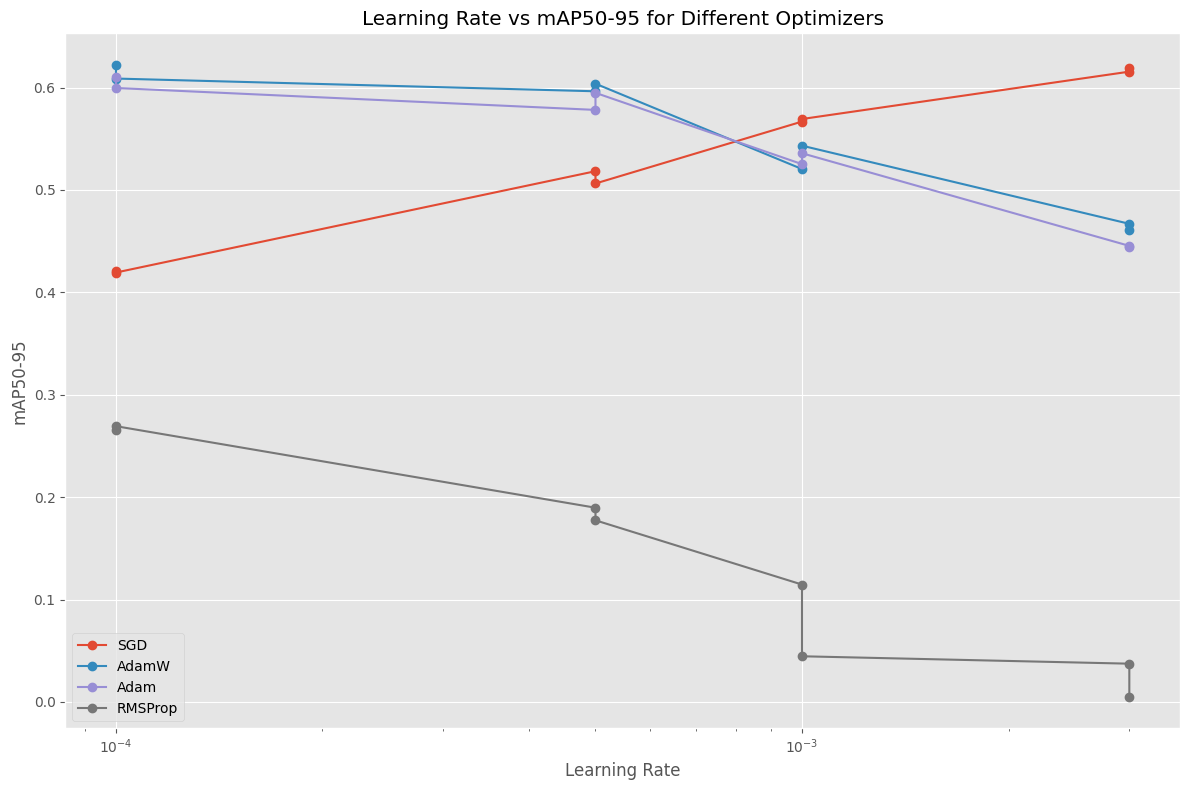

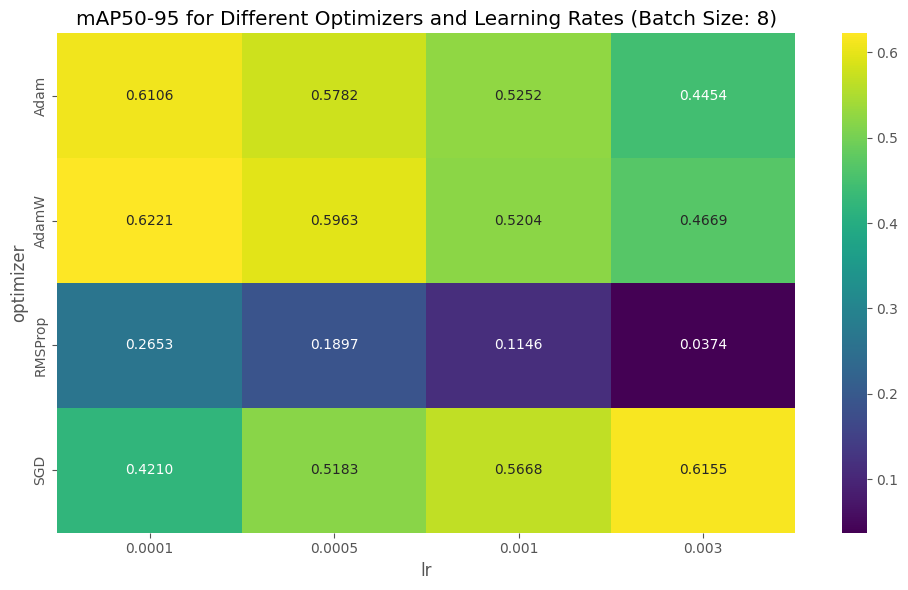

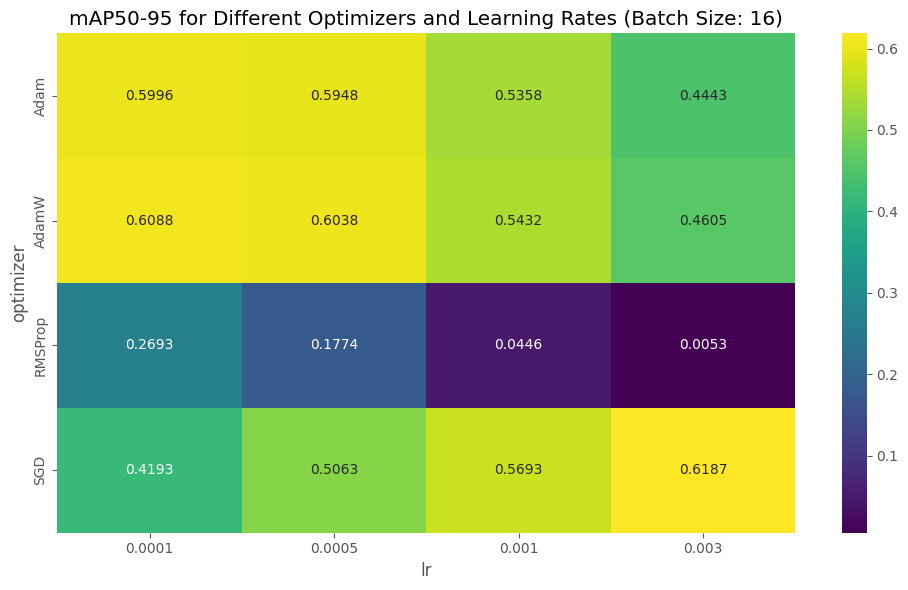

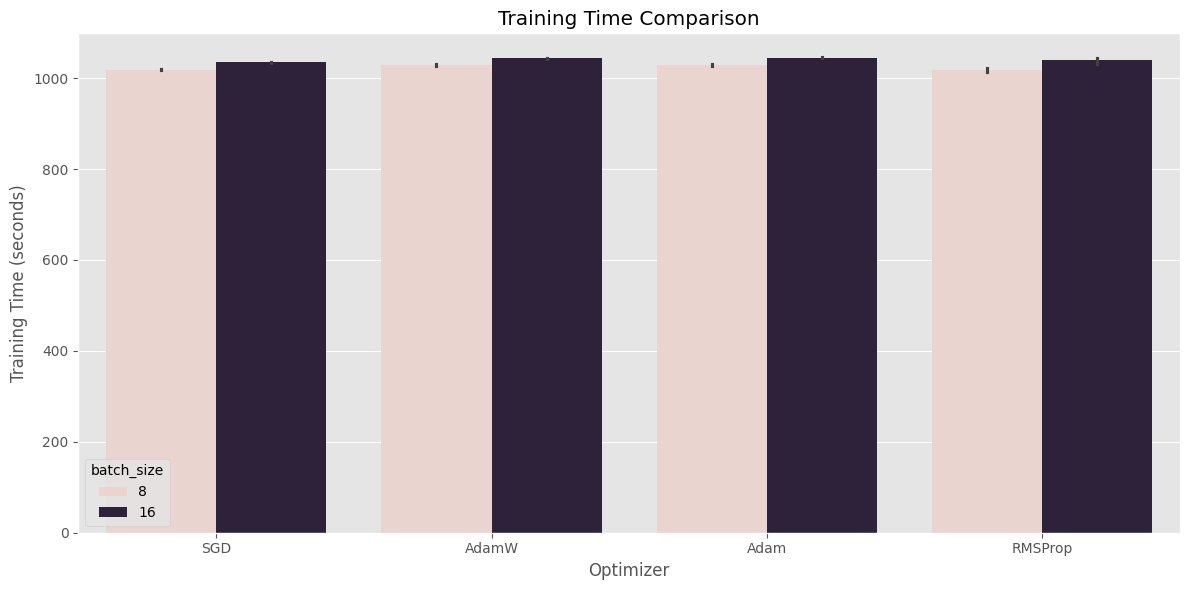

In [ ]:

    # Run grid search
    best_params = run_gridsearch()

    # Find the latest results file
    results_dir = CFG.GRIDSEARCH_DIR
    results_files = [f for f in os.listdir(results_dir) if f.endswith('.csv')]
    latest_results_file = max([os.path.join(results_dir, f) for f in results_files], key=os.path.getmtime)

    # Visualize results
    visualize_results(latest_results_file)

    # # Ask user if they want to train with best parameters
    # user_input = input("\nDo you want to train the final model with the best parameters? (y/n): ")
    # if user_input.lower() in ['y', 'yes']:
    #     final_results = train_with_best_params(best_params)